# Implementation of 'Toy language to isolate modifier dynamics' 

##from *How recurrent networks implement contextual processing in sentiment analysis* 

###by Niru Maheswaranathan & David Sussillo 

#### The paper can be found [here](https://arxiv.org/abs/2004.08013).

In the paper we implemented a synthetic language that involved valence words such as 'good', 'awesome', 'bad', and 'awful' as well as modifier words such as 'not' and 'very'. We were interested in understanding the neural dynamics by which 'not' flips the value of valence of words or how 'awesome' magnifies the value of following valence words. The language also had some noise words that had no valence, such as 'is', 'a', 'the' and 'for'.


We implemented an RNN to learn the total valence of a string of these words and set up the target to be the cumulative sum of the valence words, including the effects of the modifiers. So for example the target output for 'not good' was -1, 'not awesome' was -2, 'very awesome' 4, and so forth. 

Here we reproduce Figure 2 as well as Supplemental Figures 11, 12, 13 & 14.

The fine details of the toy language model can be found in Section 4 of the paper.

**Prerequisites** for most folks who want to understand this notebook include, in order
* [Opening the black box: low-dimensional dynamics in high-dimensional recurrent neural networks](https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00409)
* [Reverse engineering recurrent networks for sentiment classification reveals line attractor dynamics](http://papers.neurips.cc/paper/9700-reverse-engineering-recurrent-networks-for-sentiment-classification-reveals-line-attractor-dynamics)
* [How recurrent networks implement contextual processing in sentiment analysis](https://arxiv.org/abs/2004.08013)
* There is also a tutorial [fixed point analysis jupyter notebook](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/Fixed%20Point%20Finder%20Tutorial.ipynb) likely of utility to many folks as well.

In [1]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import datetime
from functools import partial
import h5py
import jax
import jax.numpy as np
from jax import grad, jacrev, jit, lax, random, vmap
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as onp
import os
from scipy.spatial.distance import pdist, squareform
import scipy.linalg
from sklearn.decomposition import PCA
from tqdm import tqdm
import time

rcParams['savefig.dpi'] = 100
MAX_SEED_INT = 10000000

In [3]:
jax.devices()

[PjRtTpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 PjRtTpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 PjRtTpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 PjRtTpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 PjRtTpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 PjRtTpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 PjRtTpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 PjRtTpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

# Code

## Fixed Point Module Code

In [4]:
"""Utility functions related reading / writing files and random keys."""


def ensure_dir(file_path):
  """Make sure the directory exists, create if it does not."""
  directory = os.path.dirname(file_path)
  if not os.path.exists(directory):
    os.makedirs(directory)


def write_file(data_fname, data_dict):
  """Write a simple dictionary using h5py."""
  try:
    ensure_dir(data_fname)
    with h5py.File(data_fname, 'w') as hf:
      for k in data_dict:
        hf.create_dataset(k, data=data_dict[k])
        # add attributes
  except IOError:
    print("Cannot write % for writing." % data_fname)
    raise


def read_file(data_fname):
  """Read a simple dictionary of np arrays using h5py."""
  try:
    with h5py.File(data_fname, 'r') as hf:
      data_dict = {k: onp.array(v) for k, v in hf.items()}
      return data_dict
  except IOError:
    print("Cannot open %s for reading." % data_fname)
    raise


def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])


def merge_losses_dicts(list_of_dicts):
  """List of dictionaries converted to dictionary of lists (numpy arrays).
  Arguments:
    list_of_dicts: list of dictionaries
  Returns:
    a single dictionary with merged keys and values of np arrays """
  merged_d = {}
  d = list_of_dicts[0]
  for k in d:
    merged_d[k] = []
  for d in list_of_dicts:
    for k in d:
      merged_d[k].append(d[k])
  for k in merged_d:
    merged_d[k] = onp.array(merged_d[k])
  return merged_d

In [5]:
"""Find the fixed points of a nonlinear system via numerical optimization."""


def find_fixed_points(rnn_fun, candidates, hps, do_print=True):
  """Top-level routine to find fixed points, keeping only valid fixed points.
  This function will:
    Add noise to the fixed point candidates ('noise_var')
    Optimize to find the closest fixed points / slow points (many hps, 
      see optimize_fps)
    Exclude any fixed points whose fixed point loss is above threshold ('fp_tol')
    Exclude any non-unique fixed points according to a tolerance ('unique_tol')
    Exclude any far-away "outlier" fixed points ('outlier_tol')
    
  This top level function runs at the CPU level, while the actual JAX optimization 
  for finding fixed points is dispatched to device.
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    candidates: ndarray with shape npoints x ndims
    hps: dict of hyper parameters for fp optimization, including
      tolerances related to keeping fixed points
  
  Returns: 
    4-tuple of (kept fixed points sorted with slowest points first, 
      fixed point losses, indicies of kept fixed points, details of 
      optimization)"""

  npoints, dim = candidates.shape
  
  noise_var = hps['noise_var']
  if do_print and noise_var > 0.0:
    print("Adding noise to fixed point candidates.")
    candidates += onp.random.randn(npoints, dim) * onp.sqrt(noise_var)
    
  if do_print:
    print("Optimizing to find fixed points.")
  fps, opt_details = optimize_fps(rnn_fun, candidates, hps, do_print)

  if do_print and hps['fp_tol'] < onp.inf:  
    print("Excluding fixed points with squared speed above tolerance {:0.5f}.".format(hps['fp_tol']))
  fps, fp_kidxs = fixed_points_with_tolerance(rnn_fun, fps, hps['fp_tol'],
                                              do_print)
  if len(fp_kidxs) == 0:
    return onp.zeros([0, dim]), onp.zeros([0]), [], opt_details
  
  if do_print and hps['unique_tol'] > 0.0:  
    print("Excluding non-unique fixed points.")
  fps, unique_kidxs = keep_unique_fixed_points(fps, hps['unique_tol'],
                                               do_print)
  if len(unique_kidxs) == 0:
    return onp.zeros([0, dim]), onp.zeros([0]), [], opt_details
  
  if do_print and hps['outlier_tol'] < onp.inf:  
    print("Excluding outliers.")
  fps, outlier_kidxs = exclude_outliers(fps, hps['outlier_tol'],
                                        'euclidean', do_print) # TODO(sussillo) Make hp?
  if len(outlier_kidxs) == 0:
    return onp.zeros([0, dim]), onp.zeros([0]), [], opt_details

  if do_print:
    print('Sorting fixed points slowest first.')    
  losses = onp.array(get_fp_loss_fun(rnn_fun)(fps))# came back as jax.interpreters.xla.DeviceArray
  sort_idxs = onp.argsort(losses) 
  fps = fps[sort_idxs]
  losses = losses[sort_idxs]
  try:
    keep_idxs = fp_kidxs[unique_kidxs[outlier_kidxs[sort_idxs]]]
  except:
    import pdb; pdb.set_trace()
  return fps, losses, keep_idxs, opt_details


def get_fp_loss_fun(rnn_fun):
  """Return the per-example mean-squared-error fixed point loss.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the loss for each example
  """
  batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))
  return jit(lambda h : np.mean((h - batch_rnn_fun(h))**2, axis=1))


def get_total_fp_loss_fun(rnn_fun):
  """Return the MSE fixed point loss averaged across examples.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1
  Returns: function that computes the average loss over all examples.
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  return jit(lambda h : np.mean(fp_loss_fun(h)))


def optimize_fp_core(batch_idx_start, num_batches, update_fun, opt_state):
  """Gradient updates to fixed points candidates in order to find fixed points.
  Uses lax.fori_loop instead of a Python loop to reduce JAX overhead. This 
    loop will be jit'd and run on device.
  Arguments:
    batch_idx_start: Where are we in the total number of batches
    num_batches: how many batches to run
    update_fun: the function that changes params based on grad of loss
    opt_state: the jax optimizer state, containing params and opt state
  Returns:
    opt_state: the jax optimizer state, containing params and optimizer state"""

  def run_update(batch_idx, opt_state):
    opt_state = update_fun(batch_idx, opt_state)
    return opt_state

  lower = batch_idx_start
  upper = batch_idx_start + num_batches
  return lax.fori_loop(lower, upper, run_update, opt_state)


optimize_fp_core_jit = jit(optimize_fp_core, static_argnums=(1, 2, 3))


def optimize_fps(rnn_fun, fp_candidates, hps, do_print=True):
  """Find fixed points of the rnn via optimization.
  This loop is at the cpu non-JAX level.
  Arguments:
    rnn_fun : RNN one step update function for a single hidden state vector
      h_t -> h_t+1, for which the fixed point candidates are trained to be 
      fixed points
    fp_candidates: np array with shape (batch size, state dim) of hidden states 
      of RNN to start training for fixed points
    hps: fixed point hyperparameters
    do_print: Print useful information? 
  Returns:
    np array of numerically optimized fixed points"""

  total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun)

  def get_update_fun(opt_update, get_params):
    """Update the parameters using gradient descent.
    Arguments:
      opt_update: a function to update the optimizer state (from jax.optimizers)
      get_params: a function that extract parametrs from the optimizer state
    Returns:
      a 2-tuple (function which updates the parameters according to the 
        optimizer, a dictionary of details of the optimization)
    """
    def update(i, opt_state):
      params = get_params(opt_state)
      grads = grad(total_fp_loss_fun)(params)    
      return opt_update(i, grads, opt_state)

    return update

  # Build some functions used in optimization.
  decay_fun = optimizers.exponential_decay(hps['step_size'],
                                           hps['decay_steps'],
                                           hps['decay_factor'])
  opt_init, opt_update, get_params = optimizers.adam(step_size=decay_fun,
                                                     b1=hps['adam_b1'],
                                                     b2=hps['adam_b2'],
                                                     eps=hps['adam_eps'])
  opt_state = opt_init(fp_candidates)
  update_fun = get_update_fun(opt_update, get_params)

  # Run the optimization, pausing every so often to collect data and
  # print status.
  batch_size = fp_candidates.shape[0]
  num_batches = hps['num_batches']
  print_every = hps['opt_print_every']
  num_opt_loops = int(num_batches / print_every)
  fps = get_params(opt_state)
  fp_losses = []
  do_stop = False
  for oidx in range(num_opt_loops):
    if do_stop:
      break
    batch_idx_start = oidx * print_every
    start_time = time.time()
    opt_state = optimize_fp_core_jit(batch_idx_start, print_every, update_fun,
                                     opt_state)
    batch_time = time.time() - start_time

    # Training loss
    fps = get_params(opt_state)
    batch_pidx = batch_idx_start + print_every
    total_fp_loss = total_fp_loss_fun(fps)
    fp_losses.append(total_fp_loss)
    
    # Saving, printing.
    if do_print:
      s = "    Batches {}-{} in {:0.2f} sec, Step size: {:0.5f}, Training loss {:0.5f}"
      print(s.format(batch_idx_start+1, batch_pidx, batch_time,
                     decay_fun(batch_pidx), total_fp_loss))

    if total_fp_loss < hps['fp_opt_stop_tol']:
      do_stop = True
      if do_print:
        print('Stopping as mean training loss {:0.5f} is below tolerance {:0.5f}.'.format(total_fp_loss, hps['fp_opt_stop_tol']))
    optimizer_details = {'fp_losses' : fp_losses}    
  return fps, optimizer_details


def fixed_points_with_tolerance(rnn_fun, fps, tol=onp.inf, do_print=True):
  """Return fixed points with a fixed point loss under a given tolerance.
  
  Arguments: 
    rnn_fun: one-step update function as a function of hidden state
    fps: ndarray with shape npoints x ndims
    tols: loss tolerance over which fixed points are excluded
    do_print: Print useful information? 
  Returns: 
    2-tuple of kept fixed points, along with indicies of kept fixed points
  """
  fp_loss_fun = get_fp_loss_fun(rnn_fun)
  losses = fp_loss_fun(fps)
  lidxs = losses < tol
  keep_idxs = onp.where(lidxs)[0]
  fps_w_tol = fps[lidxs]
  
  if do_print:
    print("    Kept %d/%d fixed points with tolerance under %f." %
          (fps_w_tol.shape[0], fps.shape[0], tol))
  
  return fps_w_tol, keep_idxs
  

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = onp.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = onp.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = onp.unique(all_drop_idxs)
  keep_idxs = onp.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = onp.array([], dtype=onp.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs


def exclude_outliers(data, outlier_dist=onp.inf, metric='euclidean', do_print=True):
  """Exclude points whose closest neighbor is further than threshold.
  Args:
    data: ndarray, matrix holding datapoints (num_points x num_features).
    outlier_dist: float, distance to determine outliers.
    metric: str or function, distance metric passed to scipy.spatial.pdist.
        Defaults to "euclidean"
    do_print: Print useful information? 
  Returns:
    2-tuple of (filtered_data: ndarray, matrix holding subset of datapoints,
      keep_idx: ndarray, vector of bools holding indices of kept datapoints).
  """
  if onp.isinf(outlier_dist):
    return data, onp.arange(len(data))
  if data.shape[0] <= 1:
    return data, onp.arange(len(data))

  # Compute pairwise distances between all fixed points.
  distances = squareform(pdist(data, metric=metric))

  # Find second smallest element in each column of the pairwise distance matrix.
  # This corresponds to the closest neighbor for each fixed point.
  closest_neighbor = onp.partition(distances, 1, axis=0)[1]

  # Return data with outliers removed and indices of kept datapoints.
  keep_idx = onp.where(closest_neighbor < outlier_dist)[0]
  data_to_keep = data[keep_idx]

  if do_print:
    print("    Kept %d/%d fixed points with within outlier tolerance %f." %
          (data_to_keep.shape[0], data.shape[0], outlier_dist))
  
  return data_to_keep, keep_idx                              


def compute_jacobians(rnn_fun, points):
  """Compute the jacobians of the rnn_fun at the points.
  This function uses JAX for the jacobian, and is computed on-device.
  Arguments:
    rnn_fun: RNN one step update function for a single hidden state vector
      h_t -> h_t+1
    points: np array npoints x dim, eval jacobian at this point.
  Returns: 
    npoints number of jacobians, np array with shape npoints x dim x dim
  """
  dFdh = jacrev(rnn_fun)
  batch_dFdh = jit(vmap(dFdh, in_axes=(0,)))
  return batch_dFdh(points)


def compute_eigenvalue_decomposition(Ms, sort_by='magnitude',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.
  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.
  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sorted left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = onp.abs
  elif sort_by == 'real':
    sort_fun = onp.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = onp.linalg.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = onp.linalg.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

## RNN Defintion

In [6]:
"""GRU functions for init, definition and running."""


def gru_params(key, **rnn_hps):
  """Generate GRU parameters
  Arguments:
    key: random.PRNGKey for random bits
    n: hidden state size
    u: input size
    i_factor: scaling factor for input weights
    h_factor: scaling factor for hidden -> hidden weights
    h_scale: scale on h0 initial condition
  Returns:
    a dictionary of parameters
  """
  key, skeys = keygen(key, 6)
  u = rnn_hps['u']              # input
  n = rnn_hps['n']              # hidden
  o = rnn_hps['o']              # output
  
  ifactor = rnn_hps['i_factor'] / np.sqrt(u)
  hfactor = rnn_hps['h_factor'] / np.sqrt(n)
  hscale = rnn_hps['h_scale']
  
  wRUH = random.normal(next(skeys), (n+n,n)) * hfactor
  wRUX = random.normal(next(skeys), (n+n,u)) * ifactor
  wRUHX = np.concatenate([wRUH, wRUX], axis=1)
  
  wCH = random.normal(next(skeys), (n,n)) * hfactor
  wCX = random.normal(next(skeys), (n,u)) * ifactor
  wCHX = np.concatenate([wCH, wCX], axis=1)

  # Include the readout params in the GRU, though technically
  # not a part of the GRU.
  pfactor = 1.0 / np.sqrt(n)
  wO = random.normal(next(skeys), (o,n)) * pfactor
  bO = np.zeros((o,))
  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wRUHX' : wRUHX,
          'wCHX' : wCHX,
          'bRU' : np.zeros((n+n,)),
          'bC' : np.zeros((n,)),
          'wO' : wO,
          'bO' : bO}


def sigmoid(x):
  """ Implement   1 / ( 1 + exp( -x ) )   in terms of tanh."""
  return 0.5 * (np.tanh(x / 2.) + 1)


def gru(params, hps, h, x, state_noise=0.0):
  """Implement the GRU equations.
  Arguments:
    params: dictionary of GRU parameters
    h: np array of  hidden state
    x: np array of input
    bfg: bias on forget gate (useful for learning if > 0.0)
  Returns:
    np array of hidden state after GRU update"""
 
  _, bfg = hps
  hx = np.concatenate([h, x], axis=0)
  ru = np.dot(params['wRUHX'], hx) + params['bRU']
  r, u = np.split(ru, 2, axis=0)
  u = u + bfg
  r = sigmoid(r)
  u = sigmoid(u)
  rhx = np.concatenate([r * h, x])
  c = np.tanh(np.dot(params['wCHX'], rhx) + params['bC'])
  return u * h + (1.0 - u) * c + state_noise


def gru_scan(params, hps, h, x_n_noise):
  """Return the output twice for scan."""
  x, state_noise = x_n_noise
  h = gru(params, hps, h, x, state_noise)
  return h, h


def affine(params, x):
  """Implement y = w x + b
  Args: 
    params: dictionary of affine parameters
    x: np array of input"""
  return np.dot(params['wO'], x) + params['bO']


# Affine expects n_W_m m_x_1, but passing in t_x_m (has txm dims) So
# map over first dimension to hand t_x_m.  I.e. if affine yields n_y_1
# = dot(n_W_m, m_x_1), then batch_affine yields t_y_n.
batch_affine = vmap(affine, in_axes=(None, 0))


def gru_run_with_h0(params, hps, x_t, h0, key):
  """Run the Vanilla RNN T steps, where T is shape[0] of input.
  Args:
    params: dict of GRU parameters
    x_t: np array of inputs with dim ntime x u
    h0: initial condition for hidden state
  Returns: 
    2-tuple of np arrays (hidden states w dim ntime x n, outputs w dim ntim x o)
  """
  noise_level, bfg = hps
  state_noise_t = noise_level * random.normal(key, shape=(x_t.shape[0], h0.shape[0]))
  f = partial(gru_scan, params, hps)
  _, h_t = lax.scan(f, h0, (x_t, state_noise_t))
  o_t = batch_affine(params, h_t)
  return h_t, o_t  


def gru_run(params, hps, x_t, key):
  """Run the Vanilla RNN T steps, where T is shape[0] of input.
  
  Args:
    params: dict of GRU parameters
    x_t: np array of inputs with dim ntime x u
  Returns: 
    2-tuple of np arrays (hidden states w dim ntime x n, outputs w dim ntim x o)
  """  
  return gru_run_with_h0(params, hps, x_t, params['h0'], key)

  
# Let's make it handle batches using `vmap`
batched_rnn_run = vmap(gru_run, in_axes=(None, None, 0, 0))
batched_rnn_run_w_h0 = vmap(gru_run_with_h0, in_axes=(None, None, 0, 0, 0))
  
  
def loss(params, hps, inputs_bxtxu, targets_bxtxo, targets_mask_bxtxo, key, l2reg):
  """Compute the least squares loss of the output, plus L2 regularization.
  Args: 
    params: dict RNN parameters
    inputs_bxtxu: np array of inputs batch x time x input dim
    targets_bxtxo: np array of targets batch x time x output dim
    targets_bxtxo: np array of weights for targets w same dims as target
    l2reg: float, hyper parameter controlling strength of L2 regularization
  
  Returns:
    dict of losses
  """
  key_b = random.split(key, inputs_bxtxu.shape[0])
  _, outs_bxtxo = batched_rnn_run(params, hps, inputs_bxtxu, key_b)
  l2_loss = l2reg * optimizers.l2_norm(params)**2
  lms_loss = np.mean((targets_mask_bxtxo * (outs_bxtxo - targets_bxtxo))**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}


def update_w_gc(i, opt_state, opt_update, get_params, hps, key,
                x_bxt, f_bxt, f_mask_bxt, max_grad_norm, l2reg):
  """Update the parameters w/ gradient clipped, gradient descent updates.
  Arguments: 
    i: batch number
    opt_state: parameters plus optimizer state
    opt_update: optimizer state update function
    get_params: function to extract parameters from optimizer state
    x_bxt: rnn inputs
    f_bxt: rnn targets
    f_mask_bxt: masks for when target is defined
    max_grad_norm: maximum norm value gradient is allowed to take
    l2reg: l2 regularization hyperparameter
  
  Returns: 
    opt_state tuple (as above) that includes updated parameters and optimzier 
      state.
  """
  params = get_params(opt_state)

  def training_loss(params, x_bxt, f_bxt, l2reg):
    return loss(params, hps, x_bxt, f_bxt, f_mask_bxt, key, l2reg)['total']
  
  grads = grad(training_loss)(params, x_bxt, f_bxt, l2reg)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)


loss_jit = jit(loss, static_argnums=(1,))
update_w_gc_jit = jit(update_w_gc, static_argnums=(2,3,4))


def run_trials(batched_run_fun, io_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary.
  
  Args: 
    batched_run_fun: function for running rnn in batch with signature either
      inputs, keys -> hiddens, outputs OR
      inputs, h0s, keys -> hiddens, outputs
    io_fun: function for creating inputs, targets, masks 
      and initial conditions. initial conditions may be None and the parameter 
      is used.  
    nbatches: Number of batches to run
    batch_size: Size of batch to run
  Returns: 
    A dictionary with the trial structure, keys are: 
      inputs, hiddens, outputs and targets, each an np array with dim
      nbatches*batch_size * ntimesteps * dim 
  """
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []
  data_seed = onp.random.randint(0, MAX_SEED_INT)  
  key = random.PRNGKey(data_seed)
  for n in range(nbatches):        
    key = random.fold_in(key, n)
    key1, key2 = random.split(key, 2)
    key_b = random.split(key1, batch_size)    
    input_b, target_b, masks_b, h0s_b = io_fun(key_b)
       
    key_b = random.split(key2, batch_size)
    if h0s_b is None:
      h_b, o_b = batched_run_fun(input_b, key_b)
    else:
      h_b, o_b = batched_run_fun(input_b, h0s_b, key_b)      
      h0s.append(h0s_b)
      
    inputs.append(input_b)
    hiddens.append(h_b)
    outputs.append(o_b)
    targets.append(target_b)
    
  trial_dict = {'inputs' : onp.vstack(inputs), 'hiddens' : onp.vstack(hiddens),
                'outputs' : onp.vstack(outputs), 'targets' : onp.vstack(targets)}
  if h0s_b is not None:
    trial_dict['h0s'] = onp.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict


def plot_params(params, hps, key, figsize):
  """Plot the parameters of the GRU.
  Args: 
    params: Parmeters of the GRU
  """
  plt.figure(figsize=figsize)
  plt.subplot(231)
  plt.stem(params['wO'][0,:])
  plt.title('wO - output weights')

  plt.subplot(232)
  plt.stem(params['h0'])
  plt.title('h0 - initial hidden state')

  plt.subplot(233)
  plt.imshow(params['wRUHX'], interpolation=None)
  plt.title('wRUHX - recurrent weights')
  plt.colorbar()
  
  plt.subplot(234)
  plt.imshow(params['wCHX'], interpolation=None)
  plt.title('wCHX')

  plt.subplot(235)
  plt.stem(params['bRU'])
  plt.title('bRU - recurrent biases')

  plt.subplot(236)
  xdim = NSymbols
  rnn_fun_h = lambda h : gru(params, hps, h, np.zeros(xdim))
  dFdh = jacrev(rnn_fun_h)(params['h0'])
  evals, _ = onp.linalg.eig(dFdh)
  x = onp.linspace(-1, 1, 1000)
  plt.plot(x, onp.sqrt(1-x**2), 'k')
  plt.plot(x, -onp.sqrt(1-x**2), 'k')
  plt.plot(onp.real(evals), onp.imag(evals), '.')
  plt.axis('equal')
  plt.xlabel('Real(lambda)')
  plt.ylabel('Imaginary(lambda)')
  plt.title('Eigenvalues of $dF/dh(h_0)$')
  
def plot_examples(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets.
  
  Args: 
    ntimesteps: Number of time steps to plot
    rnn_internals: dict returned by run_trials.
  """
  plt.figure(figsize=(nexamples*3.5, 9))
  ntoplot = NSymbols
  closeness = 1.05
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')

  ntoplot = 10
  closeness = 0.25
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'b')
    plt.xlim([0, ntimesteps])
    if bidx == 0:
      plt.ylabel('Hidden Units')

  for bidx in range(nexamples):
    plt.subplot(3, nexamples, 2*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

# Toy language generation

In [7]:
# word : from current time step t, index 1, index 2, addition to working count
NoiseSymbols = {'and' : (0, 1, 0), 'a' : (0, 1, 0), 'the': (0, 1, 0),
                'for' : (0, 1, 0), 'it' : (0, 1, 0), 'while' : (0, 1, 0)}

AdditionSymbols = {'good1': (0, 1, 1) , 'bad1' : (0, 1, -1), 
                   'awesome1' : (0, 1, 2), 'awful1' : (0, 1, -2)}

# word : from current time step t, index 1, index 2, multipication of upcoming
# symbols that are added to working count.
MultiplierSymbols = {'not4' : (1, 5, -1), 'very1' : (1, 2, 2)}

def merge_two_dicts(x,y):
  z = x.copy()
  z.update(y)
  return z

Symbols = merge_two_dicts(merge_two_dicts(NoiseSymbols, AdditionSymbols),
                          MultiplierSymbols)

SymbolNames = onp.array(list(Symbols.keys()))
SymbolNames.sort()
print('All symbols: \n\t', SymbolNames)

NoiseSymbolNames = onp.array(list(NoiseSymbols.keys()))
NoiseSymbolNames.sort()
print('\n\nNoise symbols: \n\t', NoiseSymbolNames)

AdditionSymbolNames = onp.array(list(AdditionSymbols.keys()))
AdditionSymbolNames.sort()
print('\n\nAddition symbols: \n\t', AdditionSymbolNames)

NotMultiplierSymbolNames = onp.concatenate((NoiseSymbolNames, AdditionSymbolNames))
NotMultiplierSymbolNames.sort()
print('\n\nNoise and valence symbols: \n\t', NotMultiplierSymbolNames)

NSymbols = len(SymbolNames)
NNoiseSymbols = len(NoiseSymbols)
NAdditionSymbols = len(AdditionSymbols)
NMultiplerSymbols = len(MultiplierSymbols)
NNotMultiplierSymbols = len(NotMultiplierSymbolNames)

All symbols: 
	 ['a' 'and' 'awesome1' 'awful1' 'bad1' 'for' 'good1' 'it' 'not4' 'the'
 'very1' 'while']


Noise symbols: 
	 ['a' 'and' 'for' 'it' 'the' 'while']


Addition symbols: 
	 ['awesome1' 'awful1' 'bad1' 'good1']


Noise and valence symbols: 
	 ['a' 'and' 'awesome1' 'awful1' 'bad1' 'for' 'good1' 'it' 'the' 'while']


In [8]:
def build_synthetic_review(input_params, key):
  """Build a synthetic english review and the associated rating.

  Arguments: 
    inputs_params: tuple of parameters for this sentiment analysis task
    key: jax random key for making randomness

  Returns:
    3-tuple of inputs, targets, and the target mask, indicating 
      which time points have optimization pressure on them"""
  
  string_type = 'U10' # Should be larger than any word!

  list_len = input_params[0]
  review_type = input_params[1]

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  if review_type == 'very1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'very1'

  elif review_type == 'very1-good1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'very1'
    review[idx+1] = 'good1'

  elif review_type == 'very1-awesome1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'very1'
    review[idx+1] = 'awesome1'

  elif review_type == 'very1-bad1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'very1'
    review[idx+1] = 'bad1'

  elif review_type == 'very1-awful1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'very1'
    review[idx+1] = 'awful1'

  elif review_type == 'not4-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'

  elif review_type == 'not4-good1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+1] = 'good1'

  elif review_type == 'not4-awesome1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+1] = 'awesome1'

  elif review_type == 'not4-nnn-good1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+4] = 'good1'

  elif review_type == 'not4-nnn-awesome1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+4] = 'awesome1'

  elif review_type == 'good1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx+1] = 'good1'

  elif review_type == 'awesome1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx+1] = 'awesome1'

  elif review_type == 'not4-bad1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+1] = 'bad1'

  elif review_type == 'not4-awful1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+1] = 'awful1'

  elif review_type == 'not4-nnn-bad1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+4] = 'bad1'

  elif review_type == 'not4-nnn-awful1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx] = 'not4'
    review[idx+4] = 'awful1'

  elif review_type == 'bad1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx+1] = 'bad1'

  elif review_type == 'awful1-probe':
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NNoiseSymbols)
    review = NoiseSymbolNames[onp.asarray(symbol_idxs)].astype(string_type)
    idx = int(list_len/2)
    review[idx+1] = 'awful1'

  else: # build a random review with no not4 or very1 tokens spaced closer than 4 tokens.
    symbol_idxs = random.randint(next(skeys), (list_len,), 0, NSymbols)
    review = SymbolNames[onp.asarray(symbol_idxs)]
    not_count = 0
    for widx, word in enumerate(review):
      if word == 'not4':
        if not_count > 0:
          ridx = onp.random.randint(0, NNotMultiplierSymbols)
          review[widx] = NotMultiplierSymbolNames[ridx]
        else:
          not_count = MultiplierSymbols['not4'][1]
      not_count -= 1

      very_count = 0
      if word == 'very1':
        if very_count > 0:
          ridx = onp.random.randint(0, NNotMultiplierSymbols)
          review[widx] = NotMultiplierSymbolNames[ridx]
        else:
          very_count = MultiplierSymbols['very1'][1]
      very_count -= 1

  # 'not in the center of town' is not a bad statement
  # 'very red curtains' is not a bad statement

  # Note that this will score 'not1 very1 good1' as having a value of 2.0
  # But I fear making this too complex as I won't understand the reverse 
  # engineering.
  review_idxs = []
  rating_count = onp.zeros(list_len) # could play with bias here
  # Go backwards so that the multipliers (which come beforehand in English)
  # have the values in place to multiply.
  for k, word in zip(range(list_len-1, -1, -1), onp.flipud(review)):
    k1, k2, val = Symbols[word]
    symbol_idx = onp.where(SymbolNames == word)[0][0]
    if word in AdditionSymbols:
      rating_count[k+k1:k+k2] += val

    if word in MultiplierSymbols:
      if True: # implements exact multiplier value over extent of mult symbol
        rating_count[k+k1:k+k2] *= val

      if False: # attempts something vaguely like exponential decay
        mult_len = onp.minimum(list_len - k - 1, k2 - k1)
        if word == 'very1':
          mult_scale = onp.array([(val - 1) * 0.5**k + 1 for k in range(mult_len)])
          rating_count[k+k1:k+k2] *= mult_scale
        elif word == 'not4':        
          mult_scale = onp.array([(val - 1) * 0.5**k + 1 for k in range(mult_len)])
          rating_count[k+k1:k+k2] *= mult_scale
        else:
          assert False, "NIY"

    review_idxs.append(symbol_idx)    

  review_idxs.reverse()
  rating_sum = np.sum(rating_count)
  if rating_sum == 0:
    rating = 0
  elif rating_sum > 0:
    rating = 1
  else:
    rating = -1

  inputs_txs = np.eye(NSymbols)[review_idxs]
  return inputs_txs, review_idxs, review, rating_count, rating

In [9]:
Symbols

{'and': (0, 1, 0),
 'a': (0, 1, 0),
 'the': (0, 1, 0),
 'for': (0, 1, 0),
 'it': (0, 1, 0),
 'while': (0, 1, 0),
 'good1': (0, 1, 1),
 'bad1': (0, 1, -1),
 'awesome1': (0, 1, 2),
 'awful1': (0, 1, -2),
 'not4': (1, 5, -1),
 'very1': (1, 2, 2)}

In [10]:
kidx = 0
key = random.PRNGKey(kidx)
input_txs, review_idxs, review, rating_count, rating = build_synthetic_review((50,'random'), key)
print(review)

['not4' 'while' 'awful1' 'awesome1' 'good1' 'good1' 'for' 'bad1' 'it'
 'the' 'very1' 'for' 'very1' 'awful1' 'bad1' 'very1' 'awesome1' 'it'
 'good1' 'the' 'the' 'good1' 'it' 'not4' 'for' 'very1' 'bad1' 'it' 'while'
 'it' 'while' 'bad1' 'a' 'awesome1' 'and' 'awesome1' 'awful1' 'good1'
 'and' 'a' 'for' 'for' 'very1' 'very1' 'not4' 'good1' 'awful1' 'while'
 'the' 'good1']


In [11]:
def build_synthetic_review_batch(input_params, keys):
  batch_size, input_noise, list_len = input_params[0:3]

  input_bxtxu = onp.zeros([batch_size, list_len, NSymbols])
  target_bxtxo = onp.zeros([batch_size, list_len, 1])
  target_mask_bxtxo = onp.zeros([batch_size, list_len, 1])
  for bidx in tqdm(range(batch_size)):
    input_txu, review_idxs, review, rating_count, rating = \
        build_synthetic_review(input_params[2:], keys[bidx])

    key, subkey = random.split(keys[bidx], 2)
    noise = input_noise * random.normal(subkey, shape=input_txu.shape)
    input_bxtxu[bidx,:,:] = input_txu + noise
    target_bxtxo[bidx,:,:] = np.expand_dims(np.cumsum(rating_count,axis=0),1)
    target_mask_tx1 = onp.ones([list_len,1])
    target_mask_bxtxo[bidx,:,:] = target_mask_tx1

  return input_bxtxu, target_bxtxo, target_mask_bxtxo


def build_synthetic_review_batch_all(input_params, keys):
  batch_size, input_noise, list_len = input_params[0:3]

  input_bxtxu = onp.zeros([batch_size, list_len, NSymbols])
  target_bxtxo = onp.zeros([batch_size, list_len, 1])
  target_mask_bxtxo = onp.zeros([batch_size, list_len, 1])

  reviews = []
  review_idxs = []
  rating_counts = []
  for bidx in range(batch_size):
    input_txu, review_idx_list, review, rating_count, rating = \
        build_synthetic_review(input_params[2:], keys[bidx])
    key, subkey = random.split(keys[bidx], 2)        
    noise = input_noise * random.normal(key, shape=input_txu.shape)
    input_bxtxu[bidx,:,:] = input_txu + noise
    review_idxs.append(review_idx_list)
    reviews.append(review)
    rating_counts.append(rating_count)
  

  review_idxs_bxt = onp.array(review_idxs)
  review_bxt = onp.array(reviews)
  rating_count_bxt = onp.array(rating_counts)

  return input_bxtxu, review_idxs_bxt, review_bxt, rating_count_bxt

In [12]:
input_bxtxu, review_idxs_bxt, review_bxt, rating_count_bxt = \
    build_synthetic_review_batch_all((3, 0.0, 20, 'not4-nnn-good1-probe'), random.split(key,3))

print(review_bxt, '\n')

input_bxtxu, review_idxs_bxt, review_bxt, rating_count_bxt = \
    build_synthetic_review_batch_all((3, 0.0, 20, 'very1-awesome1-probe'), random.split(key,3))

print(review_bxt)

[['for' 'and' 'for' 'for' 'for' 'and' 'the' 'a' 'it' 'and' 'not4' 'and'
  'it' 'the' 'good1' 'it' 'a' 'it' 'for' 'for']
 ['it' 'a' 'the' 'it' 'the' 'while' 'for' 'for' 'while' 'the' 'not4'
  'for' 'and' 'for' 'good1' 'while' 'while' 'a' 'the' 'and']
 ['while' 'a' 'it' 'for' 'for' 'a' 'while' 'while' 'while' 'the' 'not4'
  'for' 'the' 'while' 'good1' 'while' 'while' 'while' 'while' 'while']] 

[['for' 'and' 'for' 'for' 'for' 'and' 'the' 'a' 'it' 'and' 'very1'
  'awesome1' 'it' 'the' 'it' 'it' 'a' 'it' 'for' 'for']
 ['it' 'a' 'the' 'it' 'the' 'while' 'for' 'for' 'while' 'the' 'very1'
  'awesome1' 'and' 'for' 'while' 'while' 'while' 'a' 'the' 'and']
 ['while' 'a' 'it' 'for' 'for' 'a' 'while' 'while' 'while' 'the' 'very1'
  'awesome1' 'the' 'while' 'the' 'while' 'while' 'while' 'while' 'while']]


In [13]:
seed = 436
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

Seed: 436


Here is a simple printout of a review and the target to see how it all works.

In [14]:
inputs_txs, review_idxs, review, rating_count, rating = build_synthetic_review((50, 0.0, 'random'), key)

for a, b in zip(review, rating_count):
  print(a,b)

print('-------\n', sum(rating_count), rating)

for 0.0
a 0.0
it 0.0
for 0.0
it 0.0
for 0.0
bad1 -1.0
good1 1.0
bad1 -1.0
the 0.0
awful1 -2.0
for 0.0
awesome1 2.0
while 0.0
a 0.0
very1 0.0
a 0.0
while 0.0
and 0.0
and 0.0
not4 0.0
while -0.0
while -0.0
awful1 2.0
the -0.0
a 0.0
the 0.0
while 0.0
not4 0.0
bad1 1.0
and -0.0
bad1 1.0
it -0.0
awesome1 2.0
awesome1 2.0
awful1 -2.0
good1 1.0
good1 1.0
awful1 -2.0
awesome1 2.0
bad1 -1.0
not4 0.0
the -0.0
for -0.0
the -0.0
and -0.0
bad1 -1.0
and 0.0
and 0.0
very1 0.0
-------
 5.0 1


Generate all the reviews used to train. I chose a number of 100,000. I pre-generate them because training is way slower if you generate them during training.  This takes about 15 minutes on my computer.

In [15]:
seed = 1232119
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

TrainingSetSize = 100000
ReviewLen = 50
train_input_noise_level = 0.0

TrainInputParams = (TrainingSetSize, train_input_noise_level, ReviewLen, 'random')
EvalInputParams = (1024, 0.0, ReviewLen, 'random')

ratings = []
rating_counts = []
keys = random.split(key, TrainingSetSize)
Input_bxtxu, Target_bxtxo, TargetMask_bxtxo = build_synthetic_review_batch(TrainInputParams, keys)

100%|██████████| 100000/100000 [13:39<00:00, 121.99it/s]

Seed: 1232119


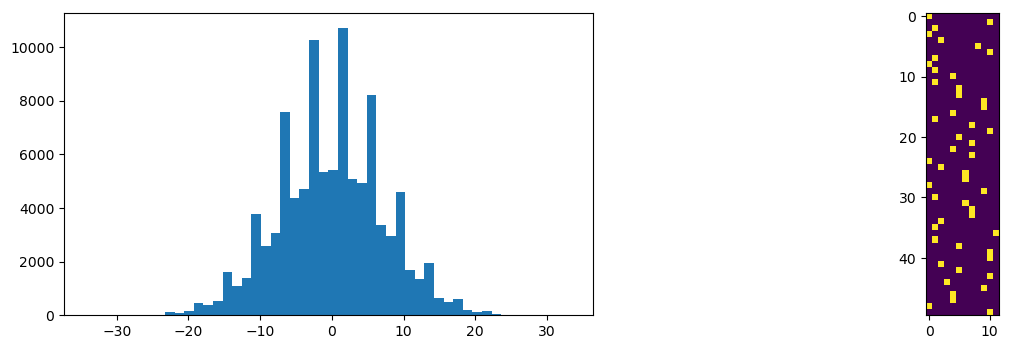

In [16]:
# Check out the histogram of final target values.
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.hist(Target_bxtxo[:,-1,:], 50);

# Make sure input is hot-one and looks good.
plt.subplot(122)
plt.imshow(Input_bxtxu[0,:,:])

In [17]:
def build_synthetic_review_batch_subselect(batch_size):
  ridxs = onp.random.randint(0, TrainingSetSize, batch_size)
  input_bxtxu = Input_bxtxu[ridxs,:,:]
  target_bxtxo = Target_bxtxo[ridxs,:,:]
  target_mask_bxtxo = TargetMask_bxtxo[ridxs,:,:]
  return input_bxtxu, target_bxtxo, target_mask_bxtxo

# Train the RNN

Now we train a GRU to generate the target output for the reviews.

### RNN Hyperparameters and Optimization Hyperparameters

In [18]:
ntimesteps = ReviewLen  
batch_size = 128

# GRU and task hyperparameters
u = NSymbols  # Number of inputs to the GRU
n = 100       # Number of units in the GRU
o = 1         # Number of outputs in the GRU
train_noise = 0.003
eval_noise = 0.0
bfg = 0.5

train_hps = (train_noise, bfg)
eval_hps = (eval_noise, bfg)

# Optimization hyperparameters
num_batchs = 40000        # Total number of batches to train on.
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.04          # initial learning rate
decay_factor = 0.99995    # decay the learning rate this much

# Gradient clipping is HUGELY important for training all RNN varieties
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0001            # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 500         # Print training informatino every so often

#### Plot the initial weights of the GRU for intuition. 

In particular notice the eigenvalue plot is just a circle distribution.

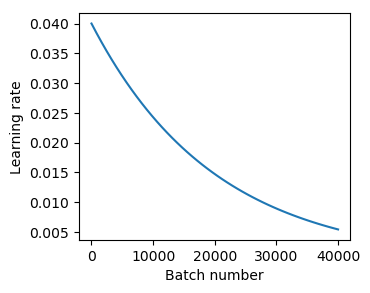

In [19]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.figure(figsize=(3.5,3))
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

Seed: 422130


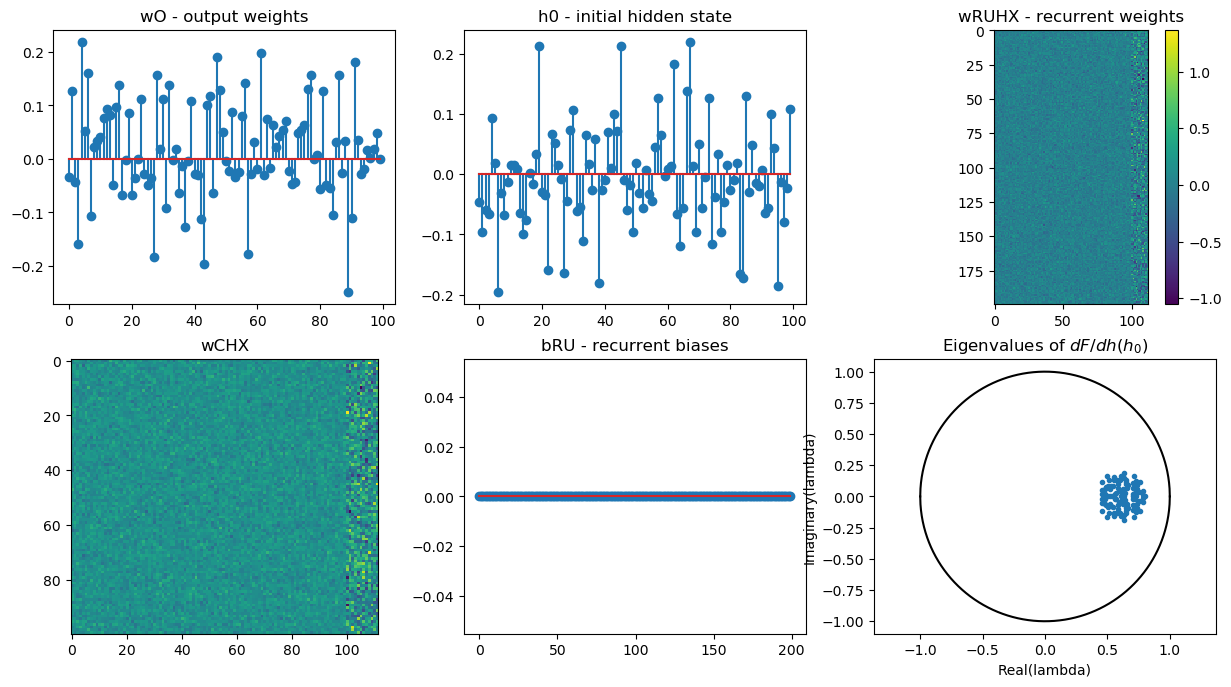

In [20]:
seed = 422130
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

key, subkey = random.split(key, 2)
init_params = gru_params(subkey, u=u, n=n, o=o,
                         i_factor=1.0, h_factor=1.0, h_scale=0.1)

plot_params(init_params, eval_hps, key, figsize=(15, 8))


## Actually train the RNN

This takes about 2-3 minutes on my computer.

In [21]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key = random.fold_in(key, batch)
    key, subkey = random.split(key, 2)
    inputs, targets, target_masks = build_synthetic_review_batch_subselect(batch_size) # uses np randomness
    opt_state = update_w_gc_jit(batch, opt_state, opt_update, get_params, train_hps, subkey, inputs,
                                targets, target_masks, max_grad_norm, l2reg)
    if batch % print_every == 0:
        key, subkey = random.split(key, 2)      
        params = get_params(opt_state)
        all_train_losses.append(loss_jit(params, eval_hps, inputs, targets, target_masks, subkey, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()

Batch 0 in 1.17 sec, step size: 0.04000, training loss 27.1896
Batch 500 in 1.65 sec, step size: 0.03901, training loss 0.2797
Batch 1000 in 1.58 sec, step size: 0.03805, training loss 0.1687
Batch 1500 in 1.57 sec, step size: 0.03711, training loss 0.1206
Batch 2000 in 1.57 sec, step size: 0.03619, training loss 0.1308
Batch 2500 in 1.59 sec, step size: 0.03530, training loss 0.1082
Batch 3000 in 1.66 sec, step size: 0.03443, training loss 0.0954
Batch 3500 in 1.59 sec, step size: 0.03358, training loss 0.1277
Batch 4000 in 1.52 sec, step size: 0.03275, training loss 0.0894
Batch 4500 in 1.54 sec, step size: 0.03194, training loss 0.0843
Batch 5000 in 1.54 sec, step size: 0.03115, training loss 0.1135
Batch 5500 in 1.52 sec, step size: 0.03038, training loss 0.0805
Batch 6000 in 1.51 sec, step size: 0.02963, training loss 0.0835
Batch 6500 in 1.51 sec, step size: 0.02890, training loss 0.1043
Batch 7000 in 1.56 sec, step size: 0.02819, training loss 0.0753
Batch 7500 in 1.56 sec, step

#### Check out the training loss

In [22]:
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

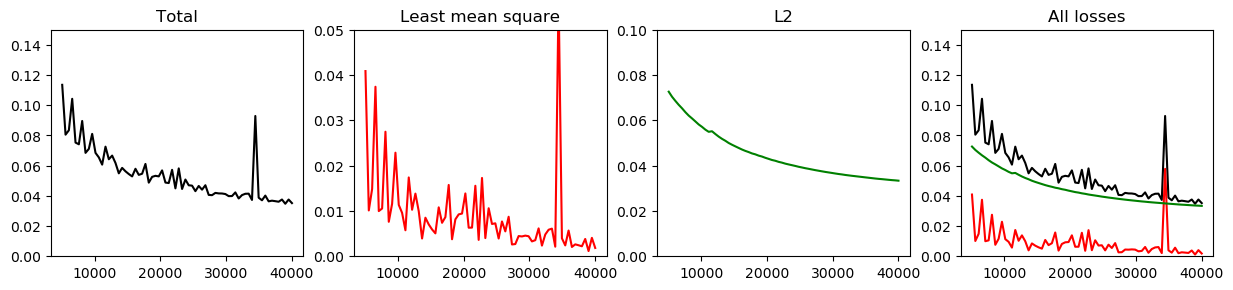

In [23]:
number_ran = len(all_train_losses['total']) * print_every
xs = onp.linspace(0, number_ran, int((number_ran / print_every)))
x1 = 10
x2 = int(number_ran / print_every)
plt.figure(figsize=(15,3))
plt.subplot(141)
plt.plot(xs[x1:x2], all_train_losses['total'][x1:x2], 'k')
plt.title('Total')
plt.ylim([0, 0.15])

plt.subplot(142)
plt.plot(xs[x1:x2], all_train_losses['lms'][x1:x2], 'r')
plt.ylim([0, 0.05])
plt.title('Least mean square')

plt.subplot(143)
plt.plot(xs[x1:x2], all_train_losses['l2'][x1:x2], 'g');
plt.title('L2')
plt.ylim([0, 0.1])

plt.subplot(144)
plt.plot(xs[x1:x2], all_train_losses['total'][x1:x2], 'k')
plt.plot(xs[x1:x2], all_train_losses['lms'][x1:x2], 'r')
plt.plot(xs[x1:x2], all_train_losses['l2'][x1:x2], 'g')
plt.title('All losses');
plt.ylim([0, 0.15]);


In [24]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation and the batch is bigger.
params = get_params(opt_state)

seed = 121218
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.
skeys = random.split(key, eval_batch_size)
inputs, targets, masks = build_synthetic_review_batch(EvalInputParams, skeys)
eval_loss = loss_jit(params, eval_hps, inputs, targets, masks, key, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

100%|██████████| 1024/1024 [00:08<00:00, 126.46it/s]

Seed: 121218
Loss on a new large batch: 0.00624


#### Basic visualizations of the state and output

In [25]:
def plot_batch(input_params, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None, ntoplot=1, figsize=(16,8)):
  """Plot some white noise / integrated white noise examples."""
  batch_size, _, ntimesteps, _ = input_params
  plt.figure(figsize=figsize)
  plt.subplot(311)
  xs = np.arange(1, ntimesteps+1)
  ninputs = input_bxtxu.shape[2]
  print(input_bxtxu[0,:,:].shape)
  for n in range(ntoplot):
    plt.plot(xs, input_bxtxu[n,:,:] + np.expand_dims(np.arange(ninputs), axis=0))
  plt.xlim([1, ntimesteps])
  plt.ylabel('Noise')

  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(xs, output_bxtxo[0:ntoplot,:,0].T);
    plt.xlim([1, ntimesteps]);
  if target_bxtxo is not None:
    plt.stem([ntimesteps]*ntoplot, target_bxtxo[0:ntoplot,ntimesteps-1,0].T, '--');
    plt.xlim([1, ntimesteps]);
    plt.ylabel("Decision")
  
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(xs, errors_bxtxo[0:ntoplot,:,0].T, '--');
    plt.xlim([1, ntimesteps]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

In [26]:
# Visualize how good this trained integrator is
nexamples = 400
input_params = (nexamples, EvalInputParams[1], EvalInputParams[2], EvalInputParams[3])
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        build_synthetic_review_batch(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None # Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs, keys: batched_rnn_run(params, eval_hps, inputs, keys)

give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

100%|██████████| 400/400 [00:03<00:00, 126.66it/s]


(50, 12)


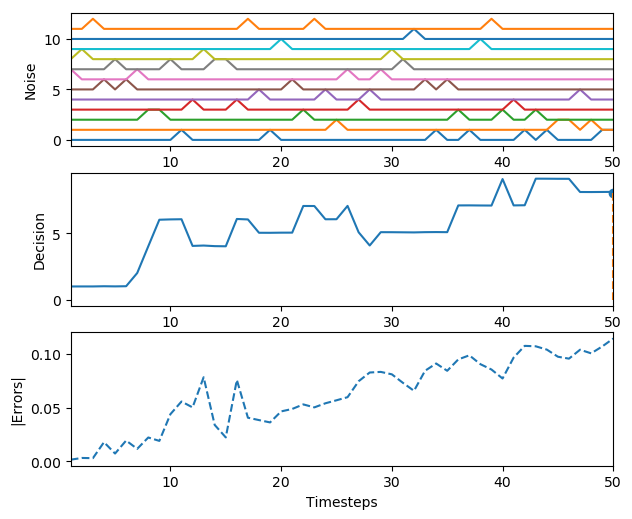

In [27]:
plot_batch(input_params, rnn_internals['inputs'], 
           rnn_internals['targets'], rnn_internals['outputs'], 
           onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), ntoplot=1, figsize=(7, 6))

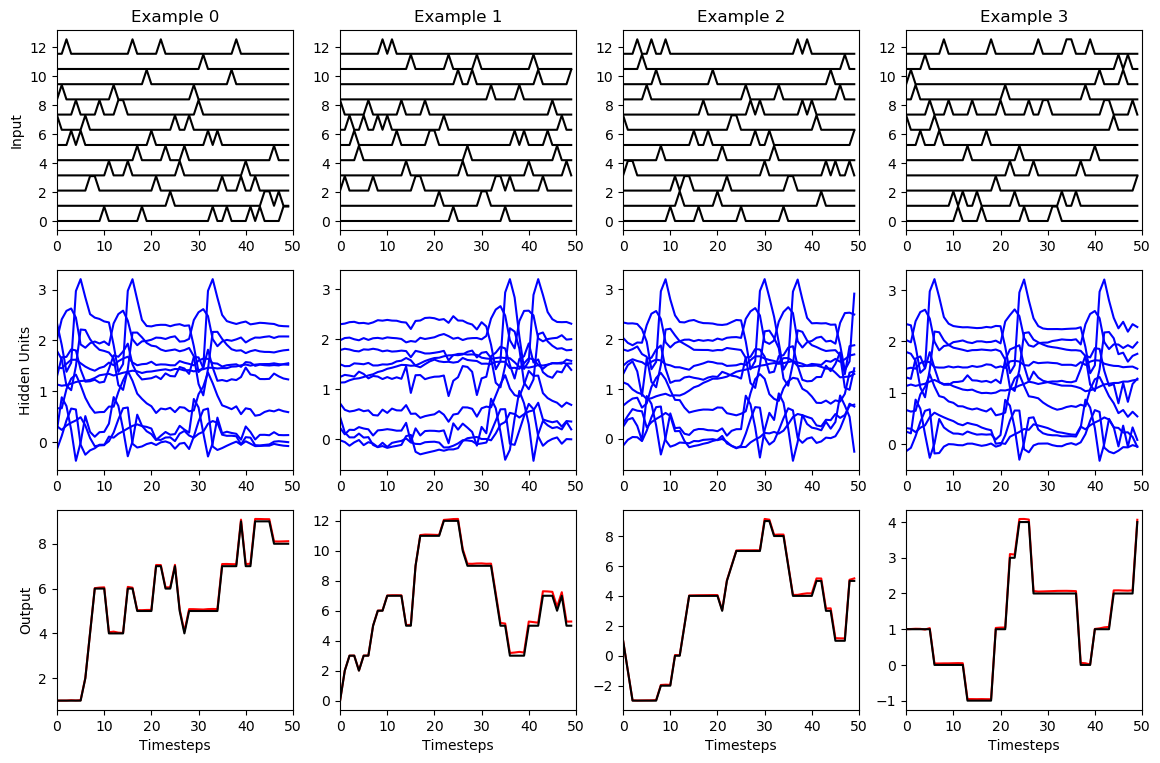

In [28]:
plot_examples(ntimesteps, rnn_internals, 4)

#### Check out the parameters after training
Notice now the eigenvalue spectra has three features. 
1. Eigenvalue(s) near (1,0) for integration
2. A complex conjugate pair (for the 'not4' token which integrates over four sequence positions (see manuscript)).
3. An eigenvalue at (0, 0) for processing 'very'

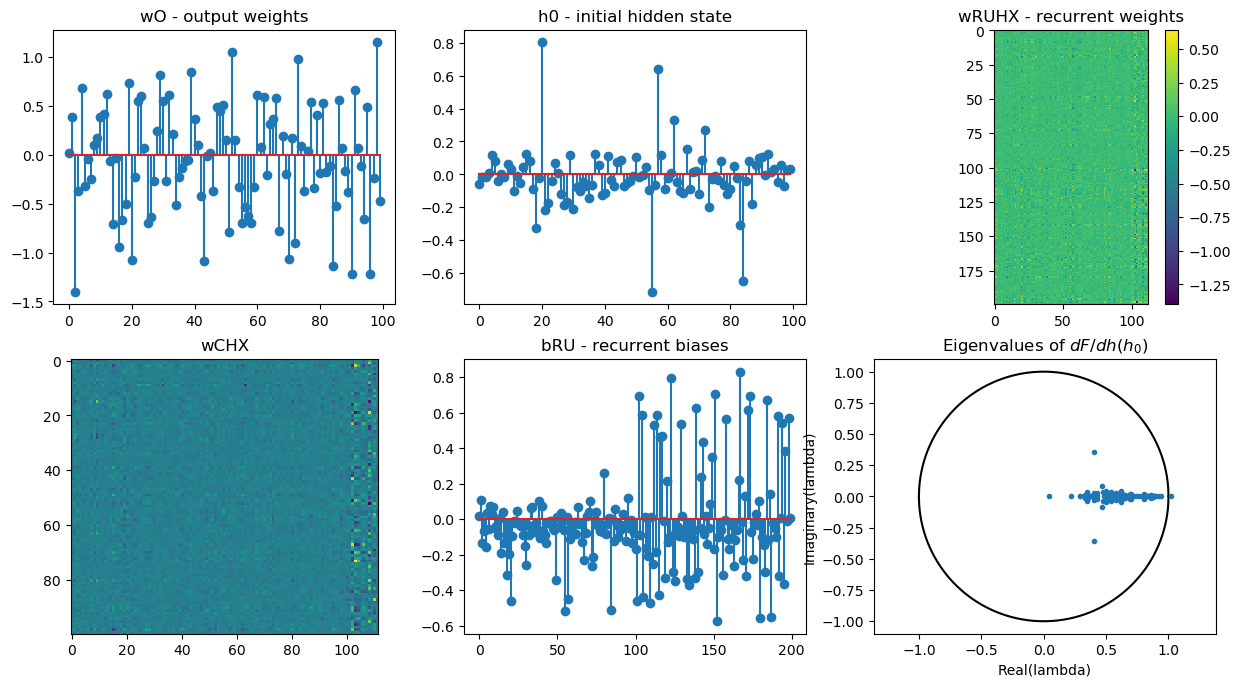

In [29]:
plot_params(params, eval_hps, key, figsize=(15,8))

### Save the network

In [30]:
# Define directories, etc.
task_type = 'not-very-perturb-study-icml2020'
rnn_type = 'gru'
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = os.path.join(os.path.join('/tmp', rnn_type), task_type)

print(data_dir)
print(fname_uniquifier)

/tmp/gru/not-very-perturb-study-icml2020
2020-08-04_15:48:20


In [31]:
# Save parameters
params_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                eval_loss_str + '_' + fname_uniquifier + '.h5')
params_fname = os.path.join(data_dir, params_fname)

print("Saving params in %s" % (params_fname))
write_file(params_fname, params)



Saving params in /tmp/gru/not-very-perturb-study-icml2020/trained_params_gru_not-very-perturb-study-icml2020_0.00624_2020-08-04_15:48:20.h5


In [32]:
%download_file /tmp/gru/not-very-perturb-study-icml2020/trained_params_gru_not-very-perturb-study-icml2020_0.00343_2020-08-04_10:09:09.h5

In [33]:
if False:
  these_params = read_file(params_fname)


# Fixed point finding optimization

Now that we've trained up this GRU, we can analyze the system via fixed point analysis.


In [34]:
# These are some preliminaries. 
x_star = np.zeros(u)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : gru(params, eval_hps, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

In [35]:
fp_loss_fun = get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's always best to start with examples of where the state normally operates.


In [36]:
fp_candidates = rnn_internals['hiddens']  # was batch x time x dim
fp_candidates = onp.reshape(fp_candidates, (-1, n)) # now batch * time x dim
onp.random.shuffle(fp_candidates)
fp_candidates = np.array(fp_candidates[:5000])

In [37]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.0125   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

When optimizing for fixed points, we set a few different stopping thresholds and run the fixed point finder a few times. This is because there are rarely true numerical-0 fixed points, though they do happen. Instead one has slow points of varying slowness. 

My experience is that if the dynamics of the slow point is very slow relative to the normal speed of the dynamics during the task / computation / behavior, then the slow point is effectively acting as a fixed point. Moving forward, in the code, and in the comments, I always refer to slow points as fixed points, with the understanding that we are being informal. By having a few tolerances of varying slowness, we ensure we capture a large variety of the fixed points and likely get a better understanding of what the system is doing.


In [38]:
# These numbers are the most important for fixed point finding and are 
# tuned to this problem in particular! 
fp_tols = [0.0001, 0.00001, 0.000002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    
    fps, fp_losses, fp_idxs, fp_opt_details = \
        find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0, 256])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]

Optimizing to find fixed points.
    Batches 1-200 in 0.47 sec, Step size: 0.19604, Training loss 0.00031
    Batches 201-400 in 0.47 sec, Step size: 0.19216, Training loss 0.00009
Stopping as mean training loss 0.00009 is below tolerance 0.00010.
Excluding fixed points with squared speed above tolerance 0.00010.
    Kept 3816/5000 fixed points with tolerance under 0.000100.
Excluding non-unique fixed points.
    Kept 3709/3816 unique fixed points with uniqueness tolerance 0.012500.
Excluding outliers.
    Kept 3709/3709 fixed points with within outlier tolerance 1.000000.
Sorting fixed points slowest first.
Optimizing to find fixed points.
    Batches 1-200 in 0.47 sec, Step size: 0.19604, Training loss 0.00031
    Batches 201-400 in 0.47 sec, Step size: 0.19216, Training loss 0.00009
    Batches 401-600 in 0.41 sec, Step size: 0.18835, Training loss 0.00005
    Batches 601-800 in 0.41 sec, Step size: 0.18462, Training loss 0.00004
    Batches 801-1000 in 0.41 sec, Step size: 0.18097,

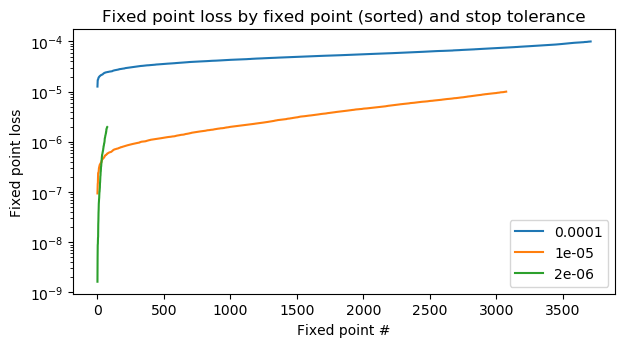

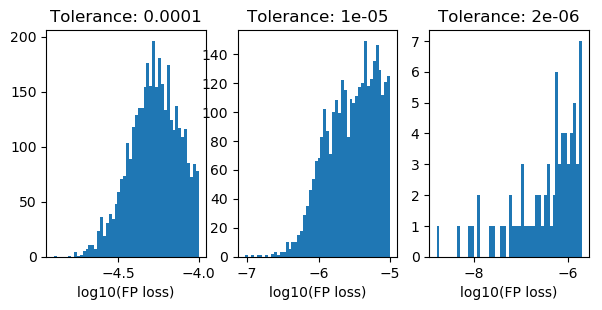

In [39]:
f1 = plt.figure(figsize=(7,3.5))

for tol in fp_tols: 
  plt.semilogy(all_fps[tol]['losses']); 
  plt.xlabel('Fixed point #')
  plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(7,3))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
  plt.subplot(1, nfp_tols, pidx); pidx += 1
  plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
  plt.xlabel('log10(FP loss)')
  plt.title('Tolerance: ' + str(tol));

We know there will be a line attractor, so let's try to get a nice representation of the line using the fixed points.  Here we use the lowest tolerance as it was chosen to deliver a couple of hundred fixed points along the line. For all of the FPs, we find the eigenvector decomposition, which is critical for our basic analyses.

In [40]:
# Sort the best fixed points by projection onto the readoud.
best_tol = fp_tols[-1]
fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params['wO'], fps.T) + onp.expand_dims(params['bO'], axis=1))
fp_ro_sidxs = onp.argsort(fp_readouts)
sorted_fp_readouts = fp_readouts[fp_ro_sidxs]
sorted_fps = fps[fp_ro_sidxs]
jacs = compute_jacobians(rnn_fun, sorted_fps)
eig_decomps = compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

Let's run the system starting at these fixed points, without input, and make sure the system is at equilibrium there. Note one can have fixed points that are very unstable, but that does not show up in this example.

As you can see, these are not true fixed points, just merely slow on the time scale of the computation.

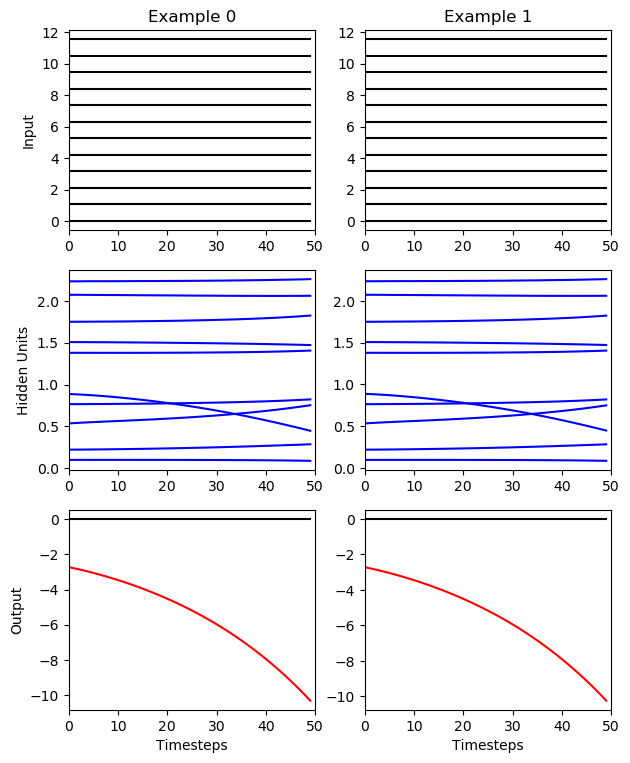

In [41]:
def no_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = np.zeros([nkeys, ntimesteps, u])
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = sorted_fps[:nkeys,:]
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs_b, h0s_b, keys: batched_rnn_run_w_h0(params, eval_hps, inputs_b, h0s_b, keys)

nexamples = len(sorted_fps)
rnn_internals_slow = run_trials(rnn_run, no_inputs_no_targets_h0s, 1, nexamples)

plot_examples(ntimesteps, rnn_internals_slow, 2)

# Contextual Processing Analysis

Now, through a series of plots and dot products, we will see how the GRU solved the NOT token in the sentiment analysis task. First we plot the fixed points, the fixed point candidates that the fixed point optimization was seeded with.

* Black shows the original candidate point, the colored dots show the fixed point, where the color of the fixed point is the projection onto the readout vector.

* So in this example, we see that the fixed point structure implements an approximate line attractor, which is the one-dimensional manifold likely used to integrate the white noise and ultimately lead to the decision (see manuscript for mathematical details).



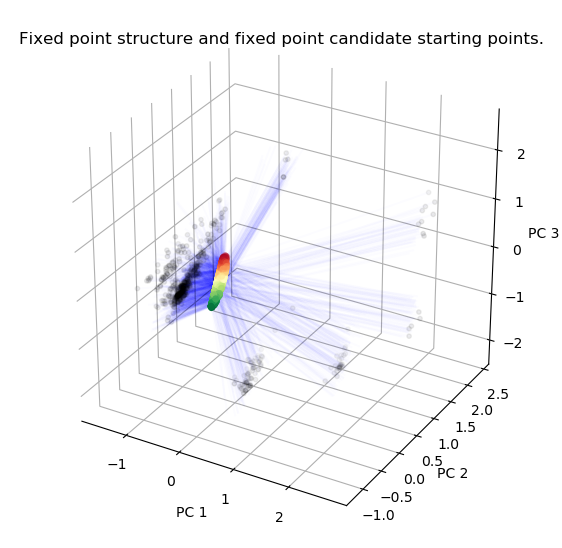

In [42]:
fig = plt.figure(figsize=(7.0,7.0));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=3).fit(fp_candidates)

alpha = 0.01
max_fps_to_plot = 2000
sizes = [100, 200]
for tol, size in zip(fp_tols[1:], sizes):
    hiddens = all_fps[tol]['candidates']
    h_pca = pca.transform(hiddens)

    emax = 500
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
    color = onp.squeeze(onp.dot(params['wO'], hstars.T) + onp.expand_dims(params['bO'], axis=1))
    
    marker_style = dict(marker='.', s=size, edgecolor='none')

    emax = hstar_pca.shape[0] if hstar_pca.shape[0] < max_fps_to_plot else max_fps_to_plot
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
               c=color[0:emax], cmap='RdYlGn', **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


Note that the readout seems to reguarly align with PC2, so use PC2 (when created from hidden state activations) as a proxy for the readout, if needed.

In [43]:
normed_readout = params['wO'] / onp.linalg.norm(params['wO'])
readout = params['wO']
onp.dot(pca.components_, normed_readout.T)

array([[ 0.33511606],
       [-0.659222  ],
       [ 0.01536307]], dtype=float32)

Another visualization of the line attractor, plotted without any additional activity and also plotted as a function of the fixed point optimization tolerance. This is really just a sanity check that the lowest tolerance got a good amount of the line attractor. 

I.e. the bottom most plot should have a good amount red, yellow and green dots.

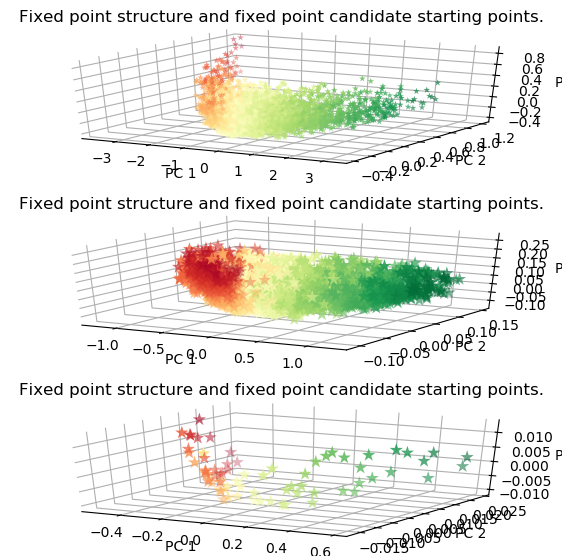

In [44]:
fig = plt.figure(figsize=(7,7));
#ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=3).fit(all_fps[fp_tols[-1]]['fps'])


max_fps_to_plot = 2000
sizes = [25, 100, 100]
idx = 1
for tol, size in zip(fp_tols[0:], sizes[0:]):
  ax = fig.add_subplot(3,1, idx, projection='3d');
  hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
  hstar_pca = pca.transform(hstars)
  color = onp.squeeze(onp.dot(params['wO'], hstars.T) + onp.expand_dims(params['bO'], axis=1))
  
  marker_style = dict(marker='*', s=size, edgecolor='none')
  
  emax = -1
  ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
            c=color[0:emax], cmap='RdYlGn', **marker_style);
  idx = idx + 1
  #plt.axis('equal')
  #ax.set_aspect('equal', 'box')     
  plt.title('Fixed point structure and fixed point candidate starting points.');
  ax.set_xlabel('PC 1')
  ax.set_ylabel('PC 2')
  ax.set_zlabel('PC 3');

  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


Now we build a whole bunch of probes to interrigate the GRU. These take the shape of batches of reviews that have noise tokens everywhere, except right in the middle. At the middle, there will be things like 

<br>
'very'
<br>
'very good'
<br>
'very bad'
<br>
...
<br>
'not good'
<br>
'not awesome'
<br>
...
<br>
'not noise noise noise good'
<br>
'not noise noise nose bad'
<br>

and so forth.

After this cell is run, we will have batches of RNN states for every single probe.

In [45]:
batch_size = 64
eval_input_noise = 0.0

input_very_bxtxu, review_idxs_very_bxt, review_very_bxt, rating_count_very_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'very1-probe'), random.split(key,batch_size))

print(review_very_bxt[0:1])

input_very_good_bxtxu, review_idxs_very_good_bxt, review_very_good_bxt, rating_count_very_good_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'very1-good1-probe'), random.split(key,batch_size))

print(review_very_good_bxt[0:1])


input_very_awesome_bxtxu, review_idxs_very_awesome_bxt, review_very_awesome_bxt, rating_count_very_awesome_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'very1-awesome1-probe'), random.split(key,batch_size))

print(review_very_awesome_bxt[0:1])


input_very_bad_bxtxu, review_idxs_very_bad_bxt, review_very_bad_bxt, rating_count_very_bad_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'very1-bad1-probe'), random.split(key,batch_size))

print(review_very_bad_bxt[0:1])


input_very_awful_bxtxu, review_idxs_very_awful_bxt, review_very_awful_bxt, rating_count_very_awful_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'very1-awful1-probe'), random.split(key,batch_size))

print(review_very_awful_bxt[0:1])


input_not_bxtxu, review_idxs_not_bxt, review_not_bxt, rating_count_not_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-probe'), random.split(key,batch_size))

print(review_not_bxt[0:1])

input_not_good_bxtxu, review_idxs_not_good_bxt, review_not_good_bxt, rating_count_not_good_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-good1-probe'), random.split(key,batch_size))

print(review_not_good_bxt[0:1])


input_not_awesome_bxtxu, review_idxs_not_awesome_bxt, review_not_awesome_bxt, rating_count_not_awesome_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-awesome1-probe'), random.split(key,batch_size))

print(review_not_awesome_bxt[0:1])


input_not_nnn_good_bxtxu, review_idxs_not_nnn_good_bxt, review_not_nnn_good_bxt, rating_count_not_nnn_good_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-nnn-good1-probe'), random.split(key,batch_size))

print(review_not_nnn_good_bxt[0:1])


input_not_nnn_awesome_bxtxu, review_idxs_not_nnn_awesome_bxt, review_not_nnn_awesome_bxt, rating_count_not_nnn_awesome_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-nnn-awesome1-probe'), random.split(key,batch_size))

print(review_not_nnn_awesome_bxt[0:1])


input_good_bxtxu, review_idxs_good_bxt, review_good_bxt, rating_count_good_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'good1-probe'), random.split(key,batch_size))

print(review_good_bxt[0:1])


input_awesome_bxtxu, review_idxs_awesome_bxt, review_awesome_bxt, rating_count_awesome_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'awesome1-probe'), random.split(key,batch_size))

print(review_awesome_bxt[0:1])


input_not_bad_bxtxu, review_idxs_not_bad_bxt, review_not_bad_bxt, rating_count_not_bad_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-bad1-probe'), random.split(key,batch_size))

print(review_not_bad_bxt[0:1])


input_not_awful_bxtxu, review_idxs_not_awful_bxt, review_not_awful_bxt, rating_count_not_awful_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-awful1-probe'), random.split(key,batch_size))

print(review_not_awful_bxt[0:1])


input_not_nnn_bad_bxtxu, review_idxs_not_nnn_bad_bxt, review_not_nnn_bad_bxt, rating_count_not_nnn_bad_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-nnn-bad1-probe'), random.split(key,batch_size))

print(review_not_nnn_bad_bxt[0:1])


input_not_nnn_awful_bxtxu, review_idxs_not_nnn_awful_bxt, review_not_nnn_awful_bxt, rating_count_not_nnn_awful_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'not4-nnn-awful1-probe'), random.split(key,batch_size))

print(review_not_nnn_awful_bxt[0:1])


input_bad_bxtxu, review_idxs_bad_bxt, review_bad_bxt, rating_count_bad_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'bad1-probe'), random.split(key,batch_size))

print(review_bad_bxt[0:1])


input_awful_bxtxu, review_idxs_awful_bxt, review_awful_bxt, rating_count_awful_bxt = \
    build_synthetic_review_batch_all((batch_size, eval_input_noise, ReviewLen, 'awful1-probe'), random.split(key,batch_size))

print(review_awful_bxt[0:1])



def very_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_very_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def very_good_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_very_good_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def very_awesome_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_very_awesome_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def very_bad_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_very_bad_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def very_awful_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_very_awful_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_good_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_good_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_awesome_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_awesome_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_nnn_good_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_nnn_good_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_nnn_awesome_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_nnn_awesome_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def good_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_good_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def awesome_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_awesome_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_bad_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_bad_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_awful_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_awful_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_nnn_bad_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_nnn_bad_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def not_nnn_awful_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_not_nnn_awful_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def bad_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_bad_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


def awful_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = input_awful_bxtxu[0:nkeys, :, :]
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = None
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b


rnn_run = lambda inputs_b, keys_b: batched_rnn_run(params, eval_hps, inputs_b, keys_b)

rnn_internals_very = run_trials(rnn_run, very_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_very_good = run_trials(rnn_run, very_good_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_very_awesome = run_trials(rnn_run, very_awesome_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_very_bad = run_trials(rnn_run, very_bad_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_very_awful = run_trials(rnn_run, very_awful_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_not = run_trials(rnn_run, not_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_not_good = run_trials(rnn_run, not_good_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_not_awesome = run_trials(rnn_run, not_awesome_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_not_nnn_good = run_trials(rnn_run, not_nnn_good_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_not_nnn_awesome = run_trials(rnn_run, not_nnn_awesome_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_good = run_trials(rnn_run, good_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_awesome = run_trials(rnn_run, awesome_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_not_bad = run_trials(rnn_run, not_bad_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_not_awful = run_trials(rnn_run, not_awful_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_not_nnn_bad = run_trials(rnn_run, not_nnn_bad_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_not_nnn_awful = run_trials(rnn_run, not_nnn_awful_inputs_no_targets_h0s, 1, batch_size)

rnn_internals_bad = run_trials(rnn_run, bad_inputs_no_targets_h0s, 1, batch_size)
rnn_internals_awful = run_trials(rnn_run, awful_inputs_no_targets_h0s, 1, batch_size)

[['and' 'for' 'the' 'and' 'the' 'it' 'and' 'a' 'the' 'it' 'it' 'a'
  'while' 'it' 'while' 'for' 'the' 'and' 'while' 'it' 'a' 'the' 'and'
  'the' 'the' 'very1' 'for' 'the' 'while' 'for' 'a' 'and' 'a' 'the' 'and'
  'while' 'for' 'the' 'for' 'the' 'the' 'and' 'it' 'it' 'while' 'it'
  'the' 'and' 'the' 'a']]
[['and' 'for' 'the' 'and' 'the' 'it' 'and' 'a' 'the' 'it' 'it' 'a'
  'while' 'it' 'while' 'for' 'the' 'and' 'while' 'it' 'a' 'the' 'and'
  'the' 'the' 'very1' 'good1' 'the' 'while' 'for' 'a' 'and' 'a' 'the'
  'and' 'while' 'for' 'the' 'for' 'the' 'the' 'and' 'it' 'it' 'while'
  'it' 'the' 'and' 'the' 'a']]
[['and' 'for' 'the' 'and' 'the' 'it' 'and' 'a' 'the' 'it' 'it' 'a'
  'while' 'it' 'while' 'for' 'the' 'and' 'while' 'it' 'a' 'the' 'and'
  'the' 'the' 'very1' 'awesome1' 'the' 'while' 'for' 'a' 'and' 'a' 'the'
  'and' 'while' 'for' 'the' 'for' 'the' 'the' 'and' 'it' 'it' 'while'
  'it' 'the' 'and' 'the' 'a']]
[['and' 'for' 'the' 'and' 'the' 'it' 'and' 'a' 'the' 'it' 'it' 'a'
  'while

You can study the network a bit by simply looking at the inputs / hiddens / targets when a probe comes in. In this case it's the probe for very awful. So for 25 or so steps the network output is zero, since everything is a probe is a noise token except for the probe inputs. Then 'very awful' comes in and the network jumps from 0 to -4, as it should.

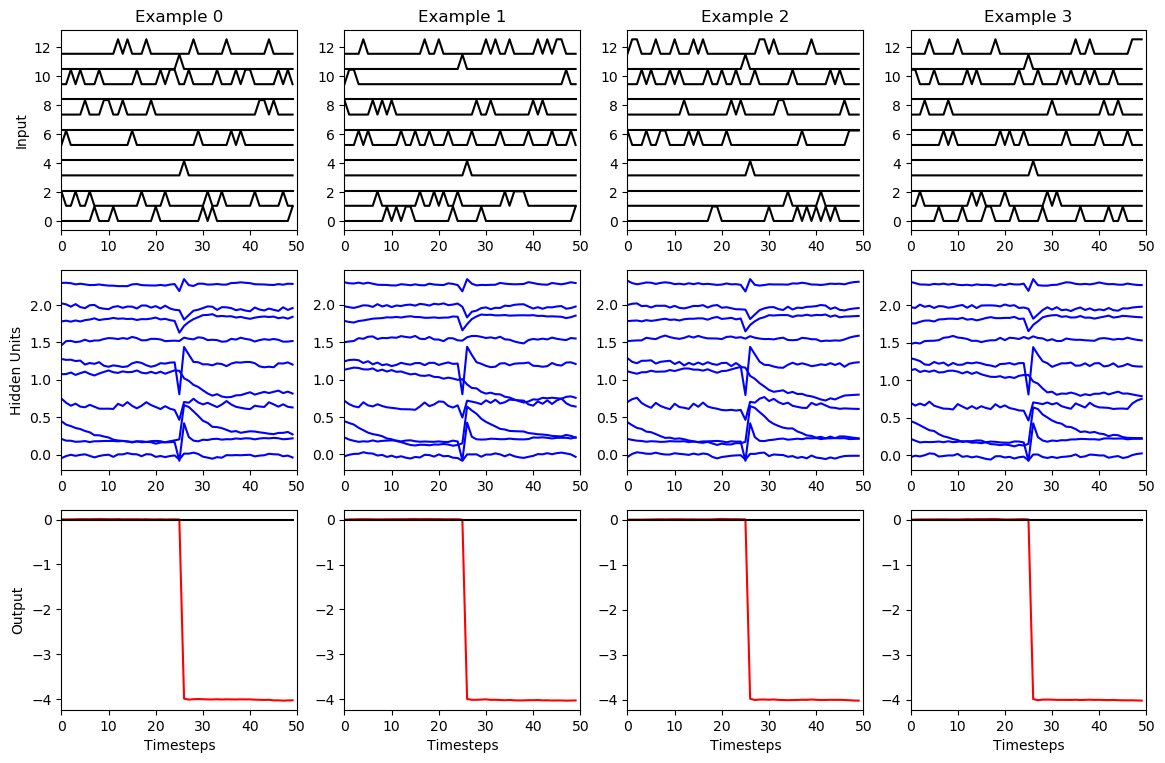

In [46]:
plot_examples(ReviewLen, rnn_internals_very_awful, 4)



It's worth taking a look at the fixed points, and the trajectories started at the fixed points, without any input, all plotted in the 3D PCA space. This a preliminary plot to Figure 2 in the manscript, which comes next in the notebook.


In [47]:
pca_data = onp.reshape(onp.concatenate((rnn_internals_very_good['hiddens'], 
                                        rnn_internals_very_bad['hiddens'], 
                                        rnn_internals_bad['hiddens'], 
                                        rnn_internals_good['hiddens'], 
                                        rnn_internals_not_bad['hiddens'], 
                                        rnn_internals_not_good['hiddens'], 
                                        rnn_internals['hiddens']), axis=0), [-1, n])

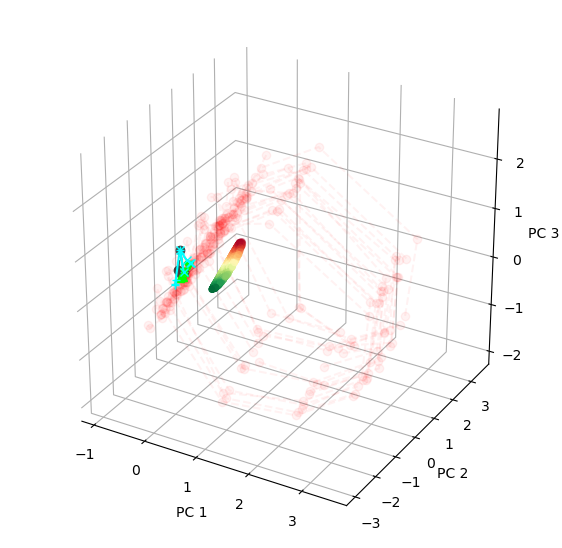

In [48]:
fig = plt.figure(figsize=(7,7));
ax = fig.add_subplot(111, projection='3d');
pca = PCA(n_components=3).fit(pca_data)

max_fps_to_plot = 2000
sizes = [50, 100, 500]
alpha = 0.5
if True:
  for tol, size in zip(fp_tols[1:2], sizes[1:2]):

      hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
      hstar_pca = pca.transform(hstars)
      color = onp.squeeze(onp.dot(params['wO'], hstars.T) + onp.expand_dims(params['bO'], axis=1))
      
      marker_style = dict(marker='.', s=size, edgecolor='none')
      
      emax = hstar_pca.shape[0]
      ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                  c=color[0:emax], cmap='RdYlGn', **marker_style);


alpha = 0.05
tidx1 = 24
tidx2 = 29 

if True:
  emax = 64
  for eidx in range(emax):
      h_pca = pca.transform(rnn_internals['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:tidx2,0], 
                h_pca[tidx1:tidx2,1],
                h_pca[tidx1:tidx2,2], '--o', c=[1.0, 0.0, 0.0, alpha])    

alpha = 1.0
emax = 1 # batch_size
for eidx in range(emax):
    h_pca = pca.transform(rnn_internals_very['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '--o', c=[0.25, 0.25, 0.25, alpha])    

    h_pca = pca.transform(rnn_internals_good['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-^', c=[0, 1, 0, alpha])    

    h_pca = pca.transform(rnn_internals_very_good['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-+', c=[0, 1, 1, alpha])    


    h_pca = pca.transform(rnn_internals_bad['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-v', c=[0, 1, 0, alpha])    

    h_pca = pca.transform(rnn_internals_very_bad['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-x', c=[0, 1, 1, alpha])    


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [49]:
c_gray_v6 = '#718096'
c_orange_v6 = '#dd6b20'
c_blue_v6 = '#3182ce'

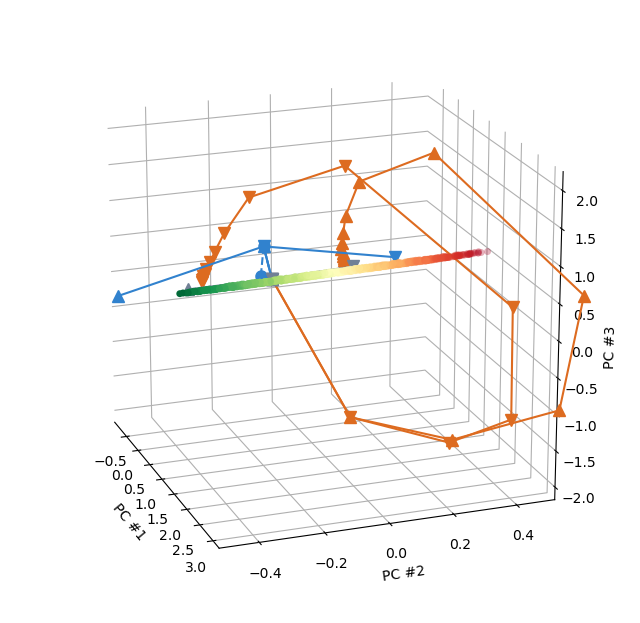

In [50]:
do_plot_not = True
do_plot_very = True

fig = plt.figure(figsize=(8, 8));
ax = fig.add_subplot(111, projection='3d');
pca = PCA(n_components=3).fit(pca_data)

max_fps_to_plot = 2000
sizes = [50, 100, 500]
alpha = 0.5
if True:
  for tol, size in zip(fp_tols[1:2], sizes[1:2]):

      hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
      hstar_pca = pca.transform(hstars)
      color = onp.squeeze(onp.dot(params['wO'], hstars.T) + onp.expand_dims(params['bO'], axis=1))
      
      marker_style = dict(marker='.', s=size, edgecolor='none')
      
      estart = 0
      estop = 1100
      emax = hstar_pca.shape[0]
      ax.scatter(hstar_pca[estart:estop,0], hstar_pca[estart:estop,1], hstar_pca[estart:estop,2], 
                  c=color[estart:estop], cmap='RdYlGn', **marker_style);


alpha = 0.05
tidx1 = 24
tidx2 = 27

not_tidx2 = 40 # 34
very_tidx2 = 27 # 27

if False:
  emax = 64
  for eidx in range(emax):
      h_pca = pca.transform(rnn_internals['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:tidx2,0], 
                h_pca[tidx1:tidx2,1],
                h_pca[tidx1:tidx2,2], '--o', c=[1.0, 0.0, 0.0, alpha])    

not_color = c_orange_v6
very_color = c_blue_v6
ms = 8
alpha = 1.
emax = 1
 #batch_size
for eidx in range(emax):
    if do_plot_not:  
      h_pca = pca.transform(rnn_internals_not_good['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:not_tidx2,0], 
                h_pca[tidx1:not_tidx2,1],
                h_pca[tidx1:not_tidx2,2], '-^', c=not_color, alpha=alpha, markersize=ms)    

      h_pca = pca.transform(rnn_internals_not_bad['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:not_tidx2,0], 
                h_pca[tidx1:not_tidx2,1],
                h_pca[tidx1:not_tidx2,2], '-v', c=not_color, alpha=alpha, markersize=ms)    

    if do_plot_very:
      h_pca = pca.transform(rnn_internals_very['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:very_tidx2,0], 
                h_pca[tidx1:very_tidx2,1],
                h_pca[tidx1:very_tidx2,2], '--o', c=very_color, alpha=alpha, markersize=ms)    


      h_pca = pca.transform(rnn_internals_very_good['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:very_tidx2,0], 
                h_pca[tidx1:very_tidx2,1],
                h_pca[tidx1:very_tidx2,2], '-^', c=very_color, alpha=alpha, markersize=ms)    

      h_pca = pca.transform(rnn_internals_very_bad['hiddens'][eidx,:,:])
      ax.plot3D(h_pca[tidx1:very_tidx2,0], 
                h_pca[tidx1:very_tidx2,1],
                h_pca[tidx1:very_tidx2,2], '-v', c=very_color, alpha=alpha, markersize=ms)    

    h_pca = pca.transform(rnn_internals_bad['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-v', c=c_gray_v6, alpha=alpha, markersize=ms)    

    h_pca = pca.transform(rnn_internals_good['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[tidx1:tidx2,0], 
              h_pca[tidx1:tidx2,1],
              h_pca[tidx1:tidx2,2], '-^', c=c_gray_v6, alpha=alpha, markersize=ms)    

ax.set_xlabel('PC #1')
ax.set_ylabel('PC #2')
ax.set_zlabel('PC #3');
ax.set_ylim([-0.5, 0.5])
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(20, -20)


### Analysis of linearized systems around the fixed points.

Glancing up at the trained parameters plot, you can see the eigenvalues of the GRU linearized around the trained initial condition, $h_0$. These eigenvalues are plotted in the complex plane. There is one eigenvalue very close to $(1,0)$ in the complex plane, this means the system can integrate. The rest of the eigenvalues are within the unit circle, meaning they are stable, decaying modes. 

Our first analysis just verifies that we actually have a line attractor and not a plane attractor or higher. We verify this by studying the top eigenvalues and seeing that eigenvalues 2 and 3 are further away from (1.0).

Below, we plot the top eigenvalues as a function of the location on the readout. The top eigenvalue is very close to $(1,0)$ across the line readout.


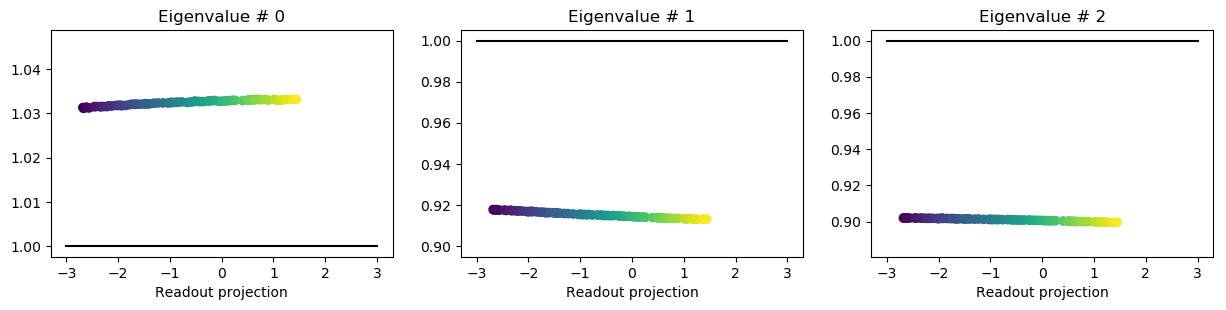

In [51]:
neigs = 3
plt.figure(figsize=(neigs*5, 3))
for eidx in range(neigs):
  max_eigs = []
  for decomp in eig_decomps:
    evals = decomp['evals']
    max_eigs.append(onp.real(evals[eidx]))

  max_eigs = onp.array(max_eigs)

  plt.subplot(1,neigs,eidx+1)
  plt.scatter(sorted_fp_readouts, max_eigs, c=sorted_fp_readouts);
  plt.plot([-3,3,], [1, 1], 'k')
  plt.axis('tight')
  plt.title('Eigenvalue # ' + str(eidx))
  plt.xlabel('Readout projection')

In [52]:
# This is the not idx, and really the index for the beginning of the action 
# in all the probes.
not_tidx = 25 

### Reproduce Supplemental Figure 12

In [53]:
very_states = rnn_internals_very['hiddens'][:, not_tidx, :]
not_states = rnn_internals_not['hiddens'][:, not_tidx, :]
pre_states = rnn_internals_not['hiddens'][:, not_tidx-1, :]
not_nnn_states = rnn_internals_not_nnn_bad['hiddens'][:, not_tidx+3]

pre_point = onp.mean(pre_states, axis=0)
very_point = onp.mean(very_states, axis=0)
not_point = onp.mean(not_states, axis=0)
not_nnn_point = onp.mean(not_nnn_states, axis=0)

In [54]:
def row_norms(A_bxn):
  return onp.sqrt(onp.sum(A_bxn * np.conj(A_bxn), axis=1))


def col_norms(A_bxn):
  return onp.sqrt(onp.sum(A_bxn * np.conj(A_bxn), axis=0))


def iter_map(h, xs):
  for x in xs: 
    h = gru(params, eval_hps, h, x)
  return h

In [55]:
HotOneInputs = {}
for word in SymbolNames:
  symbol_idx = onp.where(SymbolNames == word)[0][0]
  HotOneInputs[word] = onp.eye(NSymbols)[symbol_idx]

HotOneInputs['zero'] = onp.zeros([NSymbols])

The main point of the paper is the following: the normal effect of the inputs is well described by $\frac{\partial{F}}{\partial{x}}(h^*, x^*)$, so a linear effect around $h^*$, which is a fixed point along the line attractor. When a context word comes in, such as 'not', this moves the system away from the line attractor to a new state $h_{mod}$. At this new state, the *contextual effect* is well modeled by $\frac{\partial{F}}{\partial{x}}(h_{mod}, x^*)$ even though $h_{mod}$ is not a fixed point.

So $$w^T\; \frac{\partial{F}}{\partial{x}}(h^*, x^*=0)\;x_{good} \approx 1$$ integrates 'good' +1 along the line attractor, wich $w$ the readout. 

But $$w^T\; \frac{\partial{F}}{\partial{x}}(h_{not}, x^*=0)\;x_{good} \approx -1$$
integrates 'good' as -1 along the line attractor (after the deflection from $h^*$ to $h_{not}$).

The entire point of the context input was to move the state away from the normal integration dynamics of the line attractor into a place where something different could happen. That something is a linear update as described above.

Generate all the relevant $w^T\;\frac{\partial{F}}{\partial{x}}(h_{t-1}, x^*=0) \;x_t$.

In [56]:
key = random.PRNGKey(0) # This doesn't matter
rnn_pre_fun_x = lambda x : gru(params, eval_hps, pre_point, x )
rnn_very_fun_x = lambda x : gru(params, eval_hps, very_point, x)
rnn_not_fun_x = lambda x : gru(params, eval_hps, not_point, x)
rnn_not_nnn_fun_x = lambda x : gru(params, eval_hps, not_nnn_point, x)

dFdx_pre = jacrev(rnn_pre_fun_x)
dFdx_very = jacrev(rnn_very_fun_x)
dFdx_not = jacrev(rnn_not_fun_x)
dFdx_not_nnn = jacrev(rnn_not_nnn_fun_x)

good1 = onp.dot(dFdx_pre(HotOneInputs['zero']), 
                HotOneInputs['good1'] - HotOneInputs['zero'])
awesome1 = onp.dot(dFdx_pre(HotOneInputs['zero']), 
                   HotOneInputs['awesome1'] - HotOneInputs['zero'])

bad1 = onp.dot(dFdx_pre(HotOneInputs['zero']), 
               HotOneInputs['bad1'] - HotOneInputs['zero'])
awful1 = onp.dot(dFdx_pre(HotOneInputs['zero']), 
                  HotOneInputs['awful1'] - HotOneInputs['zero'])

very_good1 = onp.dot(dFdx_very(HotOneInputs['zero']), 
                     HotOneInputs['good1'] - HotOneInputs['zero'])

very_awesome1 = onp.dot(dFdx_very(HotOneInputs['zero']), 
                        HotOneInputs['awesome1'] - HotOneInputs['zero'])

very_bad1 = onp.dot(dFdx_very(HotOneInputs['zero']), 
                    HotOneInputs['bad1'] - HotOneInputs['zero'])

very_awful1 = onp.dot(dFdx_very(HotOneInputs['zero']), 
                      HotOneInputs['awful1'] - HotOneInputs['zero'])

not_good1 = onp.dot(dFdx_not(HotOneInputs['zero']), 
                    HotOneInputs['good1'] - HotOneInputs['zero'])

not_awesome1 = onp.dot(dFdx_not(HotOneInputs['zero']), 
                       HotOneInputs['awesome1'] - HotOneInputs['zero'])

not_bad1 = onp.dot(dFdx_not(HotOneInputs['zero']), 
                   HotOneInputs['bad1'] - HotOneInputs['zero'])
not_awful1 = onp.dot(dFdx_not(HotOneInputs['zero']), 
                     HotOneInputs['awful1'] - HotOneInputs['zero'])

not_nnn_good1 = onp.dot(dFdx_not_nnn(HotOneInputs['zero']), 
                        HotOneInputs['good1'] - HotOneInputs['zero'])
not_nnn_awesome1 = onp.dot(dFdx_not_nnn(HotOneInputs['zero']), 
                           HotOneInputs['awesome1'] - HotOneInputs['zero'])

not_nnn_bad1 = onp.dot(dFdx_not_nnn(HotOneInputs['zero']), 
                       HotOneInputs['bad1'] - HotOneInputs['zero'])

not_nnn_awful1 = onp.dot(dFdx_not_nnn(HotOneInputs['zero']), 
                         HotOneInputs['awful1'] - HotOneInputs['zero'])


good_aro = onp.dot(readout, good1) + params['bO']
awesome_aro = onp.dot(readout, awesome1) + params['bO']

bad_aro = onp.dot(readout, bad1) + params['bO']
awful_aro = onp.dot(readout, awful1) + params['bO']

very_good_aro = onp.dot(readout, very_good1) + params['bO']
very_awesome_aro = onp.dot(readout, very_awesome1) + params['bO']

very_bad_aro = onp.dot(readout, very_bad1) + params['bO']
very_awful_aro = onp.dot(readout, very_awful1) + params['bO']

not_good_aro = onp.dot(readout, not_good1) + params['bO']
not_awesome_aro = onp.dot(readout, not_awesome1) + params['bO']

not_bad_aro = onp.dot(readout, not_bad1) + params['bO']
not_awful_aro = onp.dot(readout, not_awful1) + params['bO']

not_nnn_good_aro = onp.dot(readout, not_nnn_good1) + params['bO']
not_nnn_awesome_aro = onp.dot(readout, not_nnn_awesome1) + params['bO']

not_nnn_bad_aro = onp.dot(readout, not_nnn_bad1) + params['bO']
not_nnn_awful_aro = onp.dot(readout, not_nnn_awful1) + params['bO']

aro_points = np.array([good_aro, awesome_aro, bad_aro, awful_aro, very_good_aro, 
                       very_awesome_aro, very_bad_aro, very_awful_aro, not_good_aro, 
                       not_awesome_aro, not_bad_aro, not_awful_aro, not_nnn_good_aro, 
                       not_nnn_awesome_aro, not_nnn_bad_aro, not_nnn_awful_aro])

Generate all the relevant $w^T\;F(h_{t-1}, x_t)$.

In [57]:
good_ro = onp.dot(readout, iter_map(pre_point, [HotOneInputs['good1']])) + params['bO']
awesome_ro = onp.dot(readout, iter_map(pre_point, [HotOneInputs['awesome1']])) + params['bO']

bad_ro = onp.dot(readout, iter_map(pre_point, [HotOneInputs['bad1']])) + params['bO']
awful_ro = onp.dot(readout, iter_map(pre_point, [HotOneInputs['awful1']])) + params['bO']

very_good_ro = onp.dot(readout, iter_map(very_point, [HotOneInputs['good1']])) + params['bO']
very_awesome_ro = onp.dot(readout, iter_map(very_point, [HotOneInputs['awesome1']])) + params['bO']

very_bad_ro = onp.dot(readout, iter_map(very_point, [HotOneInputs['bad1']])) + params['bO']
very_awful_ro = onp.dot(readout, iter_map(very_point, [HotOneInputs['awful1']])) + params['bO']

not_good_ro = onp.dot(readout, iter_map(not_point, [HotOneInputs['good1']])) + params['bO']
not_awesome_ro = onp.dot(readout, iter_map(not_point, [HotOneInputs['awesome1']])) + params['bO']

not_bad_ro = onp.dot(readout, iter_map(not_point, [HotOneInputs['bad1']])) + params['bO']
not_awful_ro = onp.dot(readout, iter_map(not_point, [HotOneInputs['awful1']])) + params['bO']

not_nnn_good_ro = onp.dot(readout, iter_map(not_nnn_point, [HotOneInputs['good1']])) + params['bO']
not_nnn_awesome_ro = onp.dot(readout, iter_map(not_nnn_point, [HotOneInputs['awesome1']])) + params['bO']

not_nnn_bad_ro = onp.dot(readout, iter_map(not_nnn_point, [HotOneInputs['bad1']])) + params['bO']
not_nnn_awful_ro = onp.dot(readout, iter_map(not_nnn_point, [HotOneInputs['awful1']])) + params['bO']

ar_points = np.array([good_ro, awesome_ro, bad_ro, awful_ro, very_good_ro, very_awesome_ro, 
                      very_bad_ro, very_awful_ro, not_good_ro, not_awesome_ro, not_bad_ro, 
                      not_awful_ro, not_nnn_good_ro, not_nnn_awesome_ro, not_nnn_bad_ro, not_nnn_awful_ro])

Compare the two to show the excellent agreement.

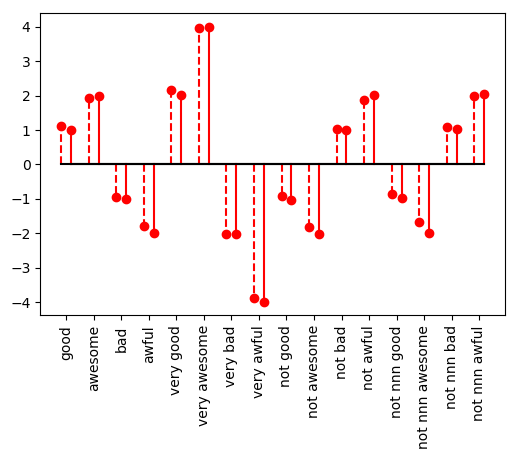

In [58]:
fig, ax = plt.subplots();
plt.stem(np.arange(len(ar_points)) - 0.18, aro_points, basefmt='k', markerfmt='ro', linefmt='r--');
plt.stem(np.arange(len(ar_points)) + 0.18, ar_points, markerfmt='ro', basefmt='k', 
         linefmt='r');

plt.xticks(np.arange(len(ar_points)));
ax.set_xticklabels(['good', 'awesome', 'bad', 'awful', 'very good', 'very awesome', 
                    'very bad', 'very awful', 'not good', 'not awesome', 'not bad', 
                    'not awful', 'not nnn good', 'not nnn awesome', 'not nnn bad', 'not nnn awful'], rotation=90);

A small point you can ignore but the parts of state space where contextual effects happen is not slow.

In [59]:
# Point here is that these points we get dfdu around are not slow.
print('Prepoint: ', onp.linalg.norm(pre_point))
print('Prepoint - prepoint(1): ', onp.linalg.norm(iter_map(pre_point, [HotOneInputs['zero']]) - pre_point))
print('Verypoint: ', onp.linalg.norm(very_point))
print('Verypoint - verypoint(1): ', onp.linalg.norm(iter_map(very_point, [HotOneInputs['zero']]) - very_point))
print('Notpoint: ', onp.linalg.norm(not_point))
print('Notpoint - notpoint(1): ', onp.linalg.norm(iter_map(not_point, [HotOneInputs['zero']]) - not_point))
print('Notnnnpoint: ', onp.linalg.norm(not_nnn_point))
print('Notnnnpoint - Notnnnpoint(1): ', onp.linalg.norm(iter_map(not_nnn_point, [HotOneInputs['zero']]) - not_nnn_point))

Prepoint:  2.266426
Prepoint - prepoint(1):  0.32418728
Verypoint:  2.5798883
Verypoint - verypoint(1):  1.7767537
Notpoint:  3.1495385
Notpoint - notpoint(1):  2.0226254
Notnnnpoint:  3.8649738
Notnnnpoint - Notnnnpoint(1):  2.9163194


### Deeper linear analyses

We wish to relate the dynamics of 'not' and 'very' back to the linear ized system, which is what is shown in Supplemental Figures 13 and 14. 

Supp. Figure 13 shows there is a nice subspace angle overlap between the deflection of the the state after a 'very' or a 'not' and the two linear modes that stick out of the mass of eigenvalues in the linear systems around the line attractor.

Supp. Figure 14 shows that if you remove that projection, the effect of the context word goes away (so 'not good' will be integrated as 'good', for example).

First, we must pick the closest point on the line atttractor to the operating point.

Fixed point indices along the line attractor for 'very', 'not', and the normal pre point:  43 43 43


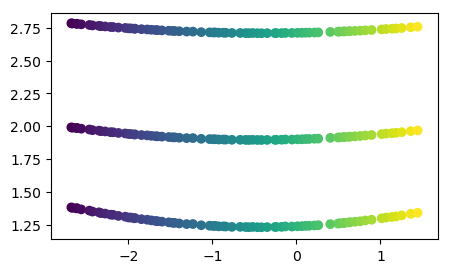

In [60]:
# Find the closest fixed point
plt.figure(figsize=(5, 3))

vs = row_norms(sorted_fps - onp.expand_dims(very_point, axis=0))
very_fp_idx = onp.argmin(vs)
very_fp = sorted_fps[very_fp_idx]

plt.scatter(sorted_fp_readouts, vs, c=sorted_fp_readouts)

ns = row_norms(sorted_fps - onp.expand_dims(not_point, axis=0))
not_fp_idx = onp.argmin(ns)
not_fp = sorted_fps[not_fp_idx]

plt.scatter(sorted_fp_readouts, ns, c=sorted_fp_readouts)

ps = row_norms(sorted_fps - onp.expand_dims(pre_point, axis=0))
pre_fp_idx = onp.argmin(ps)
pre_fp = sorted_fps[pre_fp_idx]

plt.scatter(sorted_fp_readouts, ps, c=sorted_fp_readouts)
print("Fixed point indices along the line attractor for 'very', 'not', and the normal pre point: ", very_fp_idx, not_fp_idx, pre_fp_idx)

In [61]:
LA_approx = sorted_fps[0] - sorted_fps[-1]
LA_approx_normed = LA_approx / np.linalg.norm(LA_approx)

In [62]:
def get_real_plane_from_ccpairs(M, idx):
  v1 = onp.real(M[:, idx:idx+1])
  v2 = onp.imag(M[:, idx+1:idx+2])
  plane = onp.concatenate((v1, v2), axis=1)
  plane_orth, _ = onp.linalg.qr(plane)
  return plane_orth 

def get_real_plane_from_ccpairs_fake(M, idx):
  v1 = M[:, idx:idx+1]
  v2 = M[:, idx+1:idx+2]
  plane = onp.concatenate((v1, v2), axis=1)
  return plane

#### Supplemental Figure 13

The strongest subspace overlap between the deflection of the state after modification tokens of 'very' and 'not' are the linear modes of the system that have quick deletion (since 'very' only has 1 time step effect) and the oscillatory mode (since 'not' was defined for four time steps after the 'not' token).

Very: minimum angle index:  [99] [42.47201157]
Not: minimum angle index:  [85, 86] [54.64335632 54.64336395]


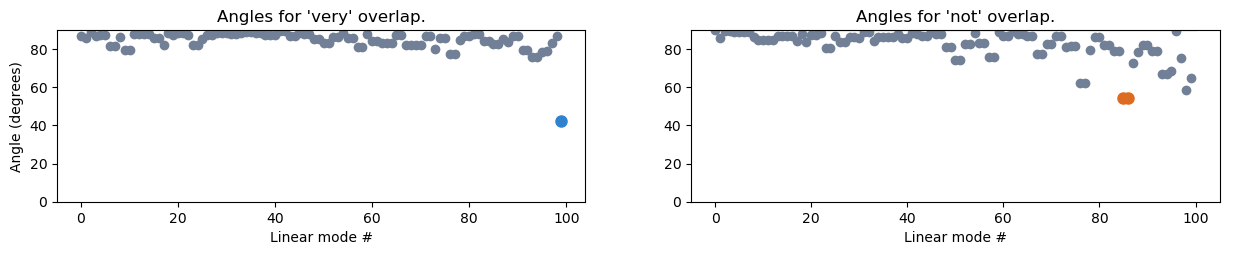

In [63]:
fig = plt.figure(figsize=(15, 5))
very_delta = np.expand_dims(very_point - very_fp, axis=1)
estruct = eig_decomps[very_fp_idx]
angles = onp.zeros(100)
for idx in range(100):
  angles[idx] = scipy.linalg.subspace_angles(very_delta, np.expand_dims(estruct['L'][:, idx], axis=1)) / np.pi * 180

very_idxs = [onp.argmin(angles)]
print('Very: minimum angle index: ', very_idxs, angles[very_idxs])
plt.subplot(221)
plt.plot(np.arange(100), angles, 'o', color=c_gray_v6)
plt.plot(very_idxs, [angles[very_idxs]], 'o', ms=8, color=c_blue_v6)
plt.ylim([0, 90])
plt.title("Angles for 'very' overlap.")
plt.ylabel('Angle (degrees)')
plt.xlabel('Linear mode #')

not_delta = np.expand_dims(not_point - not_fp, axis=1)
estruct = eig_decomps[not_fp_idx]
angles = onp.zeros(100)
for idx in range(100):
  angles[idx] = scipy.linalg.subspace_angles(not_delta, np.expand_dims(estruct['L'][:, idx], axis=1)) / np.pi * 180

first_not_idx = onp.argmin(angles)
not_idxs = [first_not_idx, first_not_idx + 1] # Get the complex conjugate pair.
print('Not: minimum angle index: ', not_idxs, angles[not_idxs])

plt.subplot(222)
plt.plot([0, 100], [90, 90], 'k')
plt.plot(angles, 'o', color=c_gray_v6)
plt.plot(not_idxs, angles[not_idxs], 'o', ms=8, color=c_orange_v6)
plt.ylim([0, 90])
plt.title("Angles for 'not' overlap.")
plt.xlabel('Linear mode #');

#### Supplental Figure 11

These show the same information but coloring the eigenvalues in the complex plane.

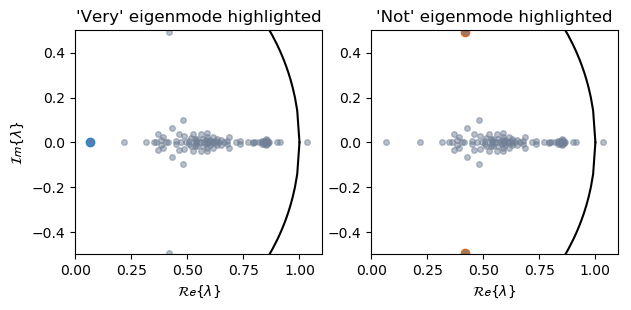

In [64]:
x = onp.linspace(-1, 1, 200)
y = onp.sqrt(1-x**2)

estruct = eig_decomps[very_fp_idx]
fig = plt.figure(figsize=(7, 4))
plt.subplot(121)
for very_idx in very_idxs:
  plt.plot(onp.real(estruct['evals'][very_idx]), 
           onp.imag(estruct['evals'][very_idx]), 'o', color=c_blue_v6, ms=6)

plt.plot(onp.real(estruct['evals']), onp.imag(estruct['evals']), 'o', ms=4, 
         color=c_gray_v6, alpha=0.5)


plt.plot(x, y, 'k')
plt.plot(x, -y, 'k')
plt.axis('square')
plt.ylim([-0.5, 0.5])
plt.xlim([0, 1.1]);
plt.title("'Very' eigenmode highlighted")
plt.xlabel(r'$\mathcal{Re}\{\lambda\}$')
plt.ylabel(r'$\mathcal{Im}\{\lambda\}$')

plt.subplot(122)
estruct = eig_decomps[not_fp_idx]
for not_idx in not_idxs:
  plt.plot(onp.real(estruct['evals'][not_idx]), 
           onp.imag(estruct['evals'][not_idx]), 'o', ms=6, color=c_orange_v6)

plt.plot(onp.real(estruct['evals']), 
         onp.imag(estruct['evals']), 'o', color=c_gray_v6, alpha=0.5, ms=4)

plt.plot(x, y, 'k')
plt.plot(x, -y, 'k')
plt.axis('square')
plt.ylim([-0.5, 0.5])
plt.xlim([0, 1.1]);
plt.title("'Not' eigenmode highlighted")
plt.xlabel(r'$\mathcal{Re}\{\lambda\}$');

## Perturbation experiment - Supplemental Figure 14

If you really believe that the linear modes are responsible for the contextual modification effects, then you should be able to delete the projection of the state into that mode and make 'not good' have the same integration as 'good', for example.

In [65]:
def kill_idxs_from_norms(L, dh, num_to_kill, do_norm_L_cols=True):
  if num_to_kill == 0:
    return []

  if do_norm_L_cols:
    Ln = [L[:, k] / onp.linalg.norm(L[:, k]) for k in range(100)]
    Ln = np.stack(Ln).T
  else:
    Ln = L
  
  left_proj = onp.abs(L.T.dot(dh))
  left_proj_idxs = onp.flipud(np.argsort(left_proj))
  return left_proj_idxs[:num_to_kill]


def is_ccp(a, b, tol=1e-4):
  is_ccp = False
  if (onp.linalg.norm(onp.imag(a)) > tol and onp.linalg.norm(onp.imag(b)) and
      onp.linalg.norm(onp.real(a) - onp.real(b)) < tol and
      onp.linalg.norm(onp.imag(a) + onp.imag(b)) < tol):
        is_ccp = True

  return is_ccp


def kill_modes(L, dh, kill_idxs):

  def get_ccp(L, kill_idxs, k):

    L_len = L.shape[1]
    if k > 0 and is_ccp(L[:, k], L[:, k-1]):
      ccp = (L[:, k-1], L[:, k])
      ks = onp.array([k-1, k])
    elif k < L_len - 1 and is_ccp(L[:, k], L[:, k+1]):
      ccp = (L[:, k], L[:, k+1])
      ks = onp.array([k, k+1])
    else:
      assert False, 'Something wrong with CCP selection. Tolerance too restrictive?'

    return ccp, ks

  num_to_kill = kill_idxs.shape[0]
  if num_to_kill == 0:
    return dh
  
  tol = 1e-5  
  my_lefts = []
  
  while kill_idxs.shape[0] > 0:
    k = kill_idxs[0]
    if onp.linalg.norm(onp.imag(L[:, k])) > tol:
      ccp, ks = get_ccp(L, kill_idxs, k)      
      my_lefts.append(np.real(ccp[0]))
      my_lefts.append(np.imag(ccp[1]))
      kill_idxs = onp.setdiff1d(kill_idxs, ks)

    else:
      my_lefts.append(np.real(L[:, k]))
      kill_idxs = onp.setdiff1d(kill_idxs, [k])

  my_lefts = np.stack(my_lefts).T
  matrix = np.hstack((my_lefts, np.reshape(dh, (-1, 1))))
  Q, R = np.linalg.qr(matrix)
  return R[-1, -1] * Q[:, -1] # R gives rescaling

#### Not perturbation experiment

[-0.9913913]


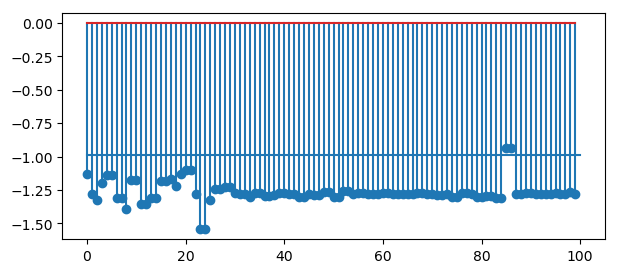

In [66]:
# Rank order the eigenvectors by how much they reduce the projection.
not_delta = onp.expand_dims(not_point - not_fp, axis=1)
L = eig_decomps[not_fp_idx]['L']
pre_bad_proj = onp.dot(readout, iter_map(pre_point, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

perturbed_projs = onp.zeros((100,))
for i in range(100):
  if i > 0 and is_ccp(L[:, i-1], L[:, i]):
    keep_idxs = onp.array([i-1, i])
  elif i < 100-1 and is_ccp(L[:, i], L[:, i+1]):
    keep_idxs = onp.array([i, i+1])
  else:
    keep_idxs = onp.array([i])
  kill_idxs = onp.setdiff1d(onp.arange(100), keep_idxs)

  not_delta_perturbed = kill_modes(L, not_delta, kill_idxs)

  not_point_perturbed = not_fp + onp.squeeze(not_delta_perturbed)
  perturbed_projs[i] = onp.dot(readout, iter_map(not_point_perturbed, 
                                                 [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

plt.figure(figsize=(7, 3))
plt.stem(perturbed_projs)
plt.plot([0, 100], [pre_bad_proj, pre_bad_proj])
print(pre_bad_proj)

[86 85 21 20  0 19  5  4 17 10  9 16 15  3 18 29 28 27 26 53 52 98 49 48
 77 76 40 39 30 68 67 95 90 89 56 55 61 60 35 34 97 78 99 70 69 73 32 31
 92 91 58 57 88 59 62 96 42 41 54 94 93 64 63 87  1 66 65 22 45 72 71 38
 47 46 82 81 37 36 33 44 43 51 50 80 79 75 74 14 13 84 83  7  6 25  2 12
 11  8 24 23]


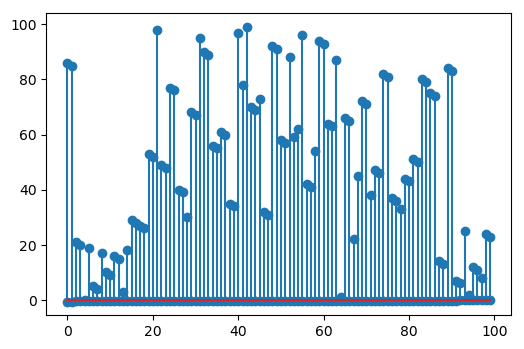

In [67]:
max_effect_idxs = onp.flipud(onp.argsort(perturbed_projs - pre_bad_proj))
plt.stem(onp.sort(perturbed_projs - pre_bad_proj))

plt.stem(max_effect_idxs)
print(max_effect_idxs)

Getting rid of the projection onto the two oscillatory modes kills nearly all of the effect of a 'not' token.

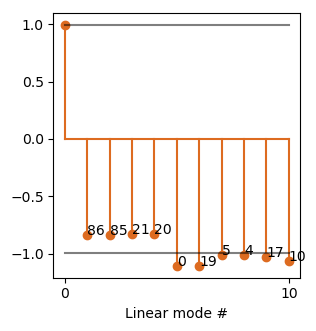

In [68]:
# Rank order the eigenvectors by how much they reduce the projection.
not_delta = onp.expand_dims(not_point - not_fp, axis=1)
L = eig_decomps[not_fp_idx]['L']
pre_bad_proj = onp.dot(readout, iter_map(pre_point, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

perturbed_projs = onp.zeros((100,))
for i in range(100):
  if i > 0 and is_ccp(L[:, i-1], L[:, i]):
    keep_idxs = onp.array([i-1, i])
  elif i < 100-1 and is_ccp(L[:, i], L[:, i+1]):
    keep_idxs = onp.array([i, i+1])
  else:
    keep_idxs = onp.array([i])
  kill_idxs = onp.setdiff1d(onp.arange(100), keep_idxs)

  not_delta_perturbed = kill_modes(L, not_delta, kill_idxs)

  not_point_perturbed = not_fp + onp.squeeze(not_delta_perturbed)
  perturbed_projs[i] = onp.dot(readout, iter_map(not_point_perturbed, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

max_effect_idxs = onp.flipud(onp.argsort(perturbed_projs - pre_bad_proj))

not_delta = onp.expand_dims(not_point - not_fp, axis=1)
L = eig_decomps[not_fp_idx]['L']
pre_bad_proj = onp.dot(readout, iter_map(pre_point, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']
not_bad_proj = onp.dot(readout, iter_map(not_point, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

perturbed_projs_ordered = onp.zeros((100,))
for i in range(100):
  # This requires hand tuning due to possibility of complex conjugate pairs.
  not_delta_perturbed = kill_modes(L, not_delta, max_effect_idxs[:i])
  not_point_perturbed = not_fp + onp.squeeze(not_delta_perturbed)
  perturbed_projs_ordered[i] = onp.dot(readout, iter_map(not_point_perturbed, [HotOneInputs['a'], HotOneInputs['a'], HotOneInputs['bad1']])) + params['bO']

ntoplot = 10
fig = plt.figure(figsize=(7, 3.5))
plt.subplot(122)
marker_lines, _, _ = \
    plt.stem(perturbed_projs_ordered[:ntoplot+1], 
             linefmt=c_orange_v6, basefmt=c_orange_v6)
marker_lines.set_markerfacecolor(c_orange_v6)
marker_lines.set_markeredgecolor(c_orange_v6)

for i in range(ntoplot):
  plt.text(i+1, perturbed_projs_ordered[i+1], str(max_effect_idxs[i]) )
plt.plot([0, ntoplot], [pre_bad_proj, pre_bad_proj], 'k', alpha=0.5)
plt.plot([0, ntoplot], [not_bad_proj, not_bad_proj], 'k', alpha=0.5)
plt.xticks([0, 10])
plt.xlabel('Linear mode #')
plt.show()

#### Very perturbation experiment

[-0.9962071]


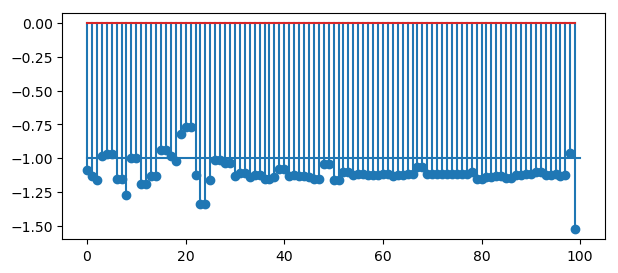

In [69]:
# Rank order the eigenvectors by how much they reduce the projection.

very_delta = onp.expand_dims(very_point - very_fp, axis=1)
L = eig_decomps[very_fp_idx]['L']
pre_bad_proj = onp.dot(readout, iter_map(pre_point, [HotOneInputs['bad1']])) + params['bO']

perturbed_projs = onp.zeros((100,))
for i in range(100):
  if i > 0 and is_ccp(L[:, i-1], L[:, i]):
    keep_idxs = onp.array([i-1, i])
  elif i < 100-1 and is_ccp(L[:, i], L[:, i+1]):
    keep_idxs = onp.array([i, i+1])
  else:
    keep_idxs = onp.array([i])
  kill_idxs = onp.setdiff1d(onp.arange(100), keep_idxs)

  very_delta_perturbed = kill_modes(L, very_delta, kill_idxs)

  very_point_perturbed = very_fp + onp.squeeze(very_delta_perturbed)
  perturbed_projs[i] = onp.dot(readout, iter_map(very_point_perturbed, [HotOneInputs['bad1']])) + params['bO']

plt.figure(figsize=(7, 3))
plt.stem(perturbed_projs)
plt.plot([0, 100], [pre_bad_proj, pre_bad_proj])
print(pre_bad_proj)

[99 24 23  8 12 11 25  2 51 50  7  6 80 79 37 36 47 46 86 85 33 45 38 82
 81 84 83 14 13 44 43 30 62  1 96 41 42 22 59 54 88 87 97 94 93 58 57 64
 63 35 34 77 76 95 56 55 61 60 66 65 70 69 73 90 89 75 74 72 71 32 31 78
 92 91 53 52  0 40 39 68 67 49 48 29 28 18 27 26 10  9  3 17  5  4 98 16
 15 19 21 20]


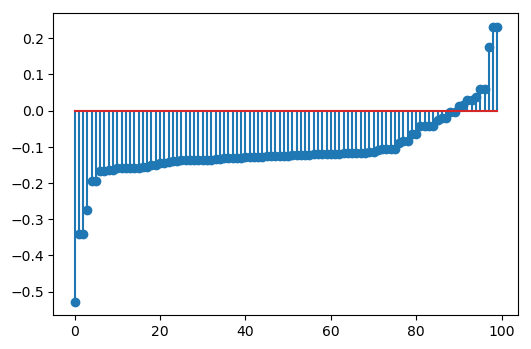

In [70]:
max_effect_idxs = onp.flipud(onp.argsort(-perturbed_projs + pre_bad_proj))
plt.stem(onp.sort(perturbed_projs - pre_bad_proj))

print(max_effect_idxs)

Getting rid of the projection onto the (0,0) instant decay mode kills nearly all of the effect of a 'very' token.

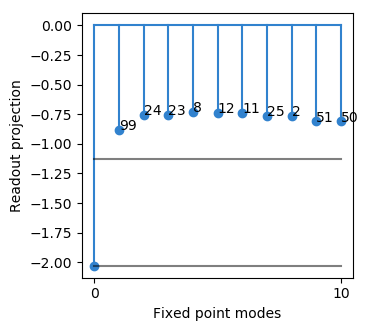

In [71]:
very_delta = onp.expand_dims(very_point - very_fp, axis=1)
L = eig_decomps[very_fp_idx]['L']
pre_bad_proj = onp.dot(readout, iter_map(very_fp, [HotOneInputs['bad1']])) + params['bO']
very_bad_proj = onp.dot(readout, iter_map(very_point, [HotOneInputs['bad1']])) + params['bO']

perturbed_projs = onp.zeros((100,))
for i in range(100):
  very_delta_perturbed = kill_modes(L, very_delta, max_effect_idxs[:i])
  very_point_perturbed = very_fp + onp.squeeze(very_delta_perturbed)
  perturbed_projs[i] = onp.dot(readout, iter_map(very_point_perturbed, [HotOneInputs['bad1']])) + params['bO']

ntoplot = 10
plt.figure(figsize=(3.5, 3.5))
marker_lines, _, _ = plt.stem(perturbed_projs[:ntoplot+1], linefmt=c_blue_v6, basefmt=c_blue_v6)
marker_lines.set_markerfacecolor(c_blue_v6)
marker_lines.set_markeredgecolor(c_blue_v6)

for i in range(ntoplot):
  plt.text(i+1, perturbed_projs[i+1], str(max_effect_idxs[i]) )
plt.plot([0, ntoplot], [pre_bad_proj, pre_bad_proj], 'k', alpha=0.5)
plt.plot([0, ntoplot], [very_bad_proj, very_bad_proj], 'k', alpha=0.5)
plt.xticks([0, 10])
plt.xlabel('Fixed point modes')
plt.ylabel('Readout projection');